In [1]:
import pandas as pd
import os
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
import numpy as np
import scipy.stats as stats
import scipy
from scipy.special import inv_boxcox
from sklearn.model_selection import KFold
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import pandas as pd
from catboost import CatBoostClassifier
import math


import warnings
warnings.filterwarnings('ignore')

MIMIC IV

In [2]:
mimic_iv_root_path ="C:\\Users\\danco\\My Drive\\Master\\Datasets\\mimic-iv-2.2\\mimic-iv-2.2\\hosp\\"
df_labs_mimic = pd.read_csv(os.path.join(mimic_iv_root_path,  'labevents.csv.gz'))
lab_metadata = pd.read_csv(os.path.join(mimic_iv_root_path, "d_labitems.csv.gz"))
df_adm = pd.read_csv(os.path.join(mimic_iv_root_path, "admissions.csv.gz"))

In [38]:
#MIMIC_IV
LAB_MAPPING = {
    'Hemoglobin': [51222, 50811],
    'Hematocrit': [51221, 50810],
    #'PH':[663,688], #697 - 15,703 rows
    #'PO2':[689,664], #694 - 15,665 rows
    'Glucose':[50931,50809],
    #'Lactate':[657, 465],
    'Bicarbonate':[50882,50803],
    'Chlorid':[50902, 50806],
    'Potassium':[50971,50822]}#,
    #'Sodium':[50983,50824]}


COLNAMES_DICT = {'VALUE_COL':'valuenum',
                 'ITEM_ID_COL':'itemid',
                 'METADATA_ITEM_ID_COL':'itemid',
                 'METADATA_NAME_COL':'label',
                 'SUBJECT_ID':'subject_id',
                 'TIME_SINCE_AD': 'Offset', #hours
                 'ROW_ID': 'labevent_id'}

In [9]:
#root_path ="C:\\Users\\danco\\My Drive\\Master\\Datasets\\MIMIC iii\\mimic-iii-clinical-database-1.4\\mimic-iii-clinical-database-1.4"
#df_labs_mimic = pd.read_csv(os.path.join(root_path,  'LABEVENTS.csv.gz'))
#dd_adm_3 = pd.read_csv(os.path.join(root_path, "admissions.csv.gz"))
dd_adm_3.DEATHTIME

0                        NaN
1                        NaN
2                        NaN
3                        NaN
4                        NaN
                ...         
58971                    NaN
58972    2151-03-06 09:10:00
58973                    NaN
58974                    NaN
58975                    NaN
Name: DEATHTIME, Length: 58976, dtype: object

In [11]:
#convert strings to numeric
non_numeric = re.compile(r'[^\d.]+')
df_labs_mimic = df_labs_mimic[~(df_labs_mimic['value'].str.contains(non_numeric, na=False))]

MIMIC III

In [12]:
#root_path ="C:\\Users\\danco\\My Drive\\Master\\Datasets\\MIMIC iii\\mimic-iii-clinical-database-1.4\\mimic-iii-clinical-database-1.4"
#df_labs_mimic = pd.read_csv(os.path.join(root_path,  'LABEVENTS.csv.gz'))
#lab_metadata = pd.read_csv(os.path.join(root_path, "D_LABITEMS.csv.gz"))
#convert strings to numeric
#non_numeric = re.compile(r'[^\d.]+')
#df_labs_mimic = df_labs_mimic[~(df_labs_mimic['VALUE'].str.contains(non_numeric, na=False))]
df_pred[COLNAMES_DICT['ITEM_ID_COL']].value_counts()

51221    3325700
51222    3188835
50971    3150261
50983    3119778
50902    3083705
50882    2972827
50931    2749562
50822     247306
50809     211004
50824     112368
50810     111637
50811     111633
50806      84527
50803      23250
Name: itemid, dtype: int64

In [11]:
import itertools

#MIMIC_IV
LAB_MAPPING = {
    'Hemoglobin': [51222, 50811],
    'Hematocrit': [51221, 50810],
    #'PH':[663,688], #697 - 15,703 rows
    #'PO2':[689,664], #694 - 15,665 rows
    'Glucose':[50931,50809],
    #'Lactate':[657, 465],
    'Bicarbonate':[50882,50803],
    'Chlorid':[50902, 50806],
    'Potassium':[50971,50822],
    'Sodium':[50983,50824]}

item_ids_list = list(itertools.chain.from_iterable((LAB_MAPPING.values()))) 



df_pred = df_labs_mimic[df_labs_mimic[COLNAMES_DICT['ITEM_ID_COL']].isin(item_ids_list)]
df_pred[COLNAMES_DICT['ITEM_ID_COL']].value_counts()

AttributeError: 'DataFrame' object has no attribute 'item_id'

In [266]:
# initialize data of lists.

art_vein_mapping = pd.DataFrame({'lab_name':       ['Hemoglobin', 'Glucose', 'Chloride', 'Hematocrit','Potassium', 'Sodium', 'Bicarbonate'],
                                 'vein_itemid':    [ 51222,        50931,     50902,      51221,       50971,       50983,    50882],
                                 'artery_itemid':  [ 50811,        50809,     50806,      50810,       50822,       50824,    50803]})
art_vein_mapping

lab_name  vein_itemid  artery_itemid
0   Hemoglobin        51222          50811
1      Glucose        50931          50809
2     Chloride        50902          50806
3   Hematocrit        51221          50810
4    Potassium        50971          50822
5       Sodium        50983          50824
6  Bicarbonate        50882          50803

(16612, 10)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


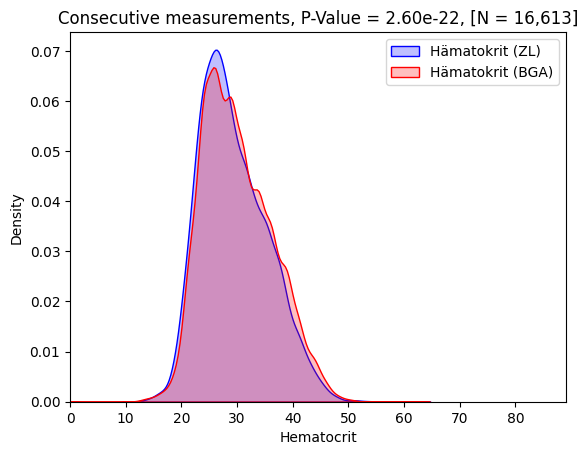

(16613, 11)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


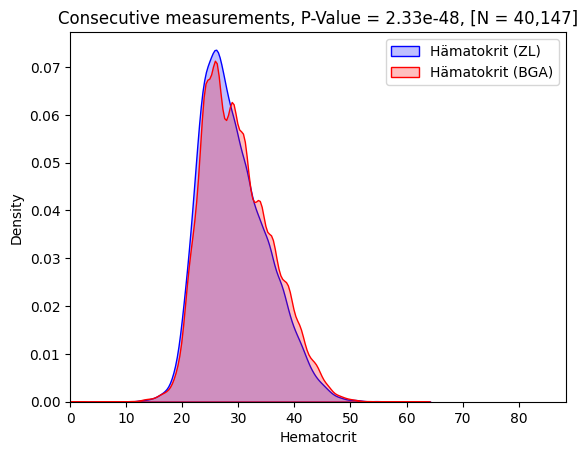

(40147, 11)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


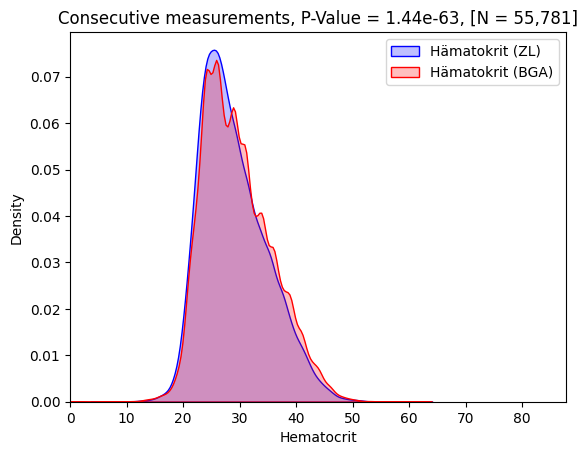

(55781, 11)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


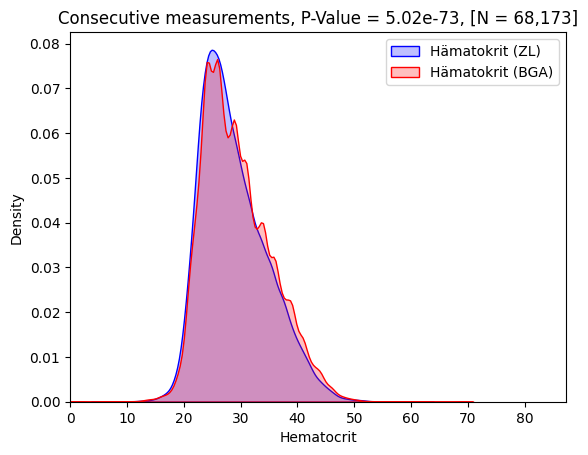

(68173, 11)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


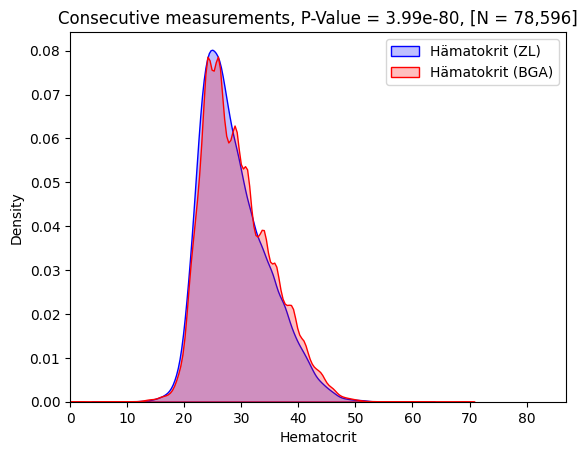

(78596, 11)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


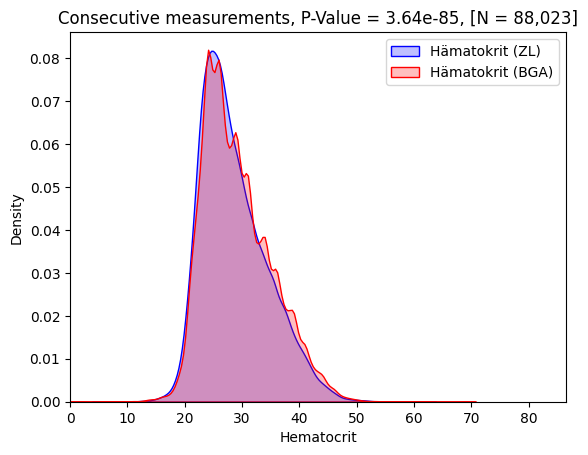

(88023, 11)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


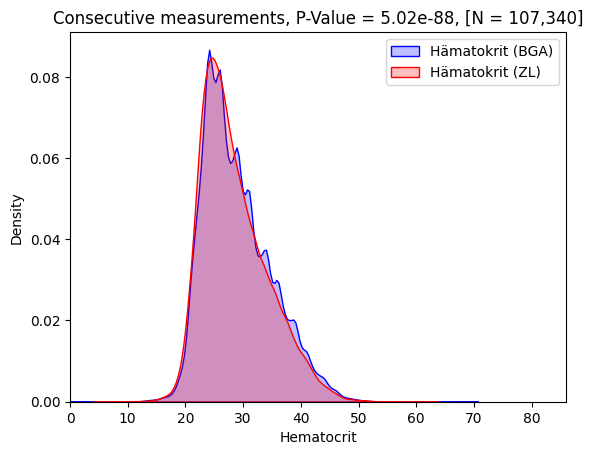

(107340, 11)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


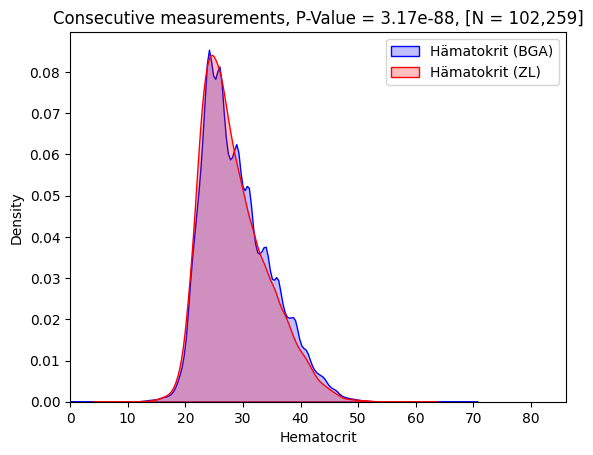

In [252]:
def all_measurements_plot(df,COLNAMES_DICT, FEATURE_NAME,plot_type):
    counts_per_id = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin(LAB_MAPPING[FEATURE_NAME])][COLNAMES_DICT['ITEM_ID_COL']].value_counts()

    top_id = counts_per_id.index[0]
    next_id = counts_per_id.index[1]

    top_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == top_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    next_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == next_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    
    df[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df[COLNAMES_DICT['VALUE_COL']])
        
    if(plot_type == 'first'):
        df  = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id, next_id])].groupby([COLNAMES_DICT['SUBJECT_ID'],COLNAMES_DICT['ITEM_ID_COL']]).first().reset_index()

    if((plot_type == 'first') | (plot_type == 'all')):
        p_val = stats.ttest_ind(pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']]),
                                pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']]))[1]
        text_p_val = "{:.2e}".format(p_val)
    if(plot_type == 'consecutive'):
        p_val = stats.ttest_rel(pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']]),
                                pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']]))[1]
        text_p_val = "{:.2e}".format(p_val)
        
    max_xlim = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id,next_id])][COLNAMES_DICT['VALUE_COL']].mean()*3
    min_xlim = 0
    if (round(max_xlim,0) == 0): #data was standerdized
        max_xlim = 5
        min_xlim = -5
    fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
    fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)
    if(plot_type == 'first'):
        plt.title(f'First measurement per subject, P-Value = {text_p_val}')
    if(plot_type == 'all'):
        plt.title(f'All measurements, P-Value = {text_p_val}')
    if(plot_type == 'consecutive'):
        plt.title(f'Consecutive measurements, P-Value = {text_p_val}, [N = {int(len(df)/2):,}]')


    plt.xlim(min_xlim,max_xlim)
    plt.xlabel(FEATURE_NAME)

    plt.legend()        
    if(plot_type == 'first'):
        plt.savefig(f'{FEATURE_NAME}_first_measurements.jpg')
    if(plot_type == 'all'):
        plt.savefig(f'{FEATURE_NAME}_all_measurements.jpg')
    if(plot_type == 'consecutive'):
        plt.savefig(f'{FEATURE_NAME}_consecutive.jpg')

    plt.show()

    return(p_val)

COLNAMES_DICT = {'VALUE_COL':'LaboratoryValue',
                 'ITEM_ID_COL':'LaboratoryID',
                 'METADATA_ITEM_ID_COL':'ReferenceGlobalID',
                 'METADATA_NAME_COL':'ReferenceValue',
                 'SUBJECT_ID':'CaseID',
                 'TIME_SINCE_AD': 'Offset',
                 'ROW_ID': 'id'}

LAB_MAPPING = {
    'Hemoglobin': [289, 658],
    'Hematocrit': [217, 682],
    'PH':[663,688], #697 - 15,703 rows
    'PO2':[689,664], #694 - 15,665 rows
    'Glucose':[656,348],
    'Lactate':[657, 465],
    'Chlorid':[683, 450],
    'Potassium':[685,463],
    'Sodium':[469,686]}

import scipy.stats as stats
t_lab_name = 'Hematocrit'

df_lab = pd.read_csv(f'sicdb_{t_lab_name}_consecutive.csv')

max_int = 40 #minutes

p_val_list = []

for max_int in (5,10):
    print(df_lab_t.shape)
    df_lab_t = df_lab[df_lab.delta_time < max_int]

    df_lab_t = df_lab_t[(~df_lab_t[COLNAMES_DICT['VALUE_COL']].isna()) & (~df_lab_t.next_VALUENUM.isna())]

    next_values = df_lab_t[['next_ITEMID','next_VALUENUM']].rename(columns={"next_ITEMID": COLNAMES_DICT['ITEM_ID_COL'], "next_VALUENUM": COLNAMES_DICT['VALUE_COL']})
    current_values =  df_lab_t[[COLNAMES_DICT['ITEM_ID_COL'],COLNAMES_DICT['VALUE_COL']]]

    total_data = pd.concat([current_values,next_values],axis =0)
    total_data.LaboratoryID = pd.to_numeric(total_data.LaboratoryID)

    p_val = all_measurements_plot(total_data,COLNAMES_DICT, t_lab_name,plot_type='consecutive')
    p_val_list.append(p_val)

(17440, 10)


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


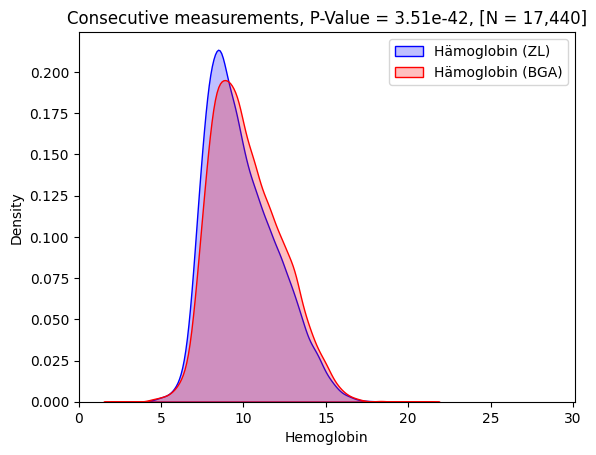

In [371]:
import scipy.stats as stats
t_lab_name = 'Hemoglobin'

df_lab = pd.read_csv(f'sicdb_{t_lab_name}_consecutive.csv', index_col=[0])

df_lab = df_lab[(df_lab['next_VALUENUM'] != 'END') & (df_lab[COLNAMES_DICT['VALUE_COL']] != 'END')]

df_lab['next_VALUENUM'] = pd.to_numeric(df_lab['next_VALUENUM'])
df_lab[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df_lab[COLNAMES_DICT['VALUE_COL']])

df_lab = df_lab[(df_lab[COLNAMES_DICT['VALUE_COL']] >0) & (df_lab['next_VALUENUM'] >0)]
df_lab = df_lab[(df_lab[COLNAMES_DICT['VALUE_COL']] <100) & (df_lab['next_VALUENUM'] <100)]



max_int = 5 #minutes

p_val_list = []

print(df_lab_t.shape)
df_lab_t = df_lab[df_lab.delta_time < max_int]


df_lab_t = df_lab_t[(~df_lab_t[COLNAMES_DICT['VALUE_COL']].isna()) & (~df_lab_t.next_VALUENUM.isna())]

next_values = df_lab_t[['next_ITEMID','next_VALUENUM']].rename(columns={"next_ITEMID": COLNAMES_DICT['ITEM_ID_COL'], "next_VALUENUM": COLNAMES_DICT['VALUE_COL']})
current_values =  df_lab_t[[COLNAMES_DICT['ITEM_ID_COL'],COLNAMES_DICT['VALUE_COL']]]

total_data = pd.concat([current_values,next_values],axis =0)
total_data.LaboratoryID = pd.to_numeric(total_data.LaboratoryID)

p_val = all_measurements_plot(total_data,COLNAMES_DICT, t_lab_name,plot_type='consecutive')
p_val_list.append(p_val)

C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1523090022.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)


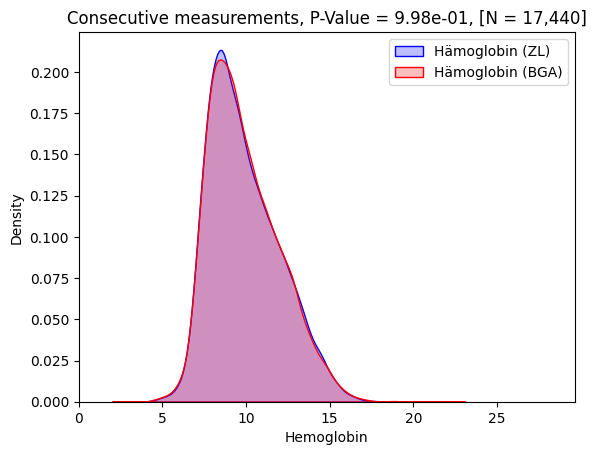

In [370]:
import numpy as np
from scipy.special import inv_boxcox

counts_per_id = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']].isin(LAB_MAPPING[t_lab_name])][COLNAMES_DICT['ITEM_ID_COL']].value_counts()

top_id = counts_per_id.index[0]
next_id = counts_per_id.index[1]

df_top = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == top_id]
df_next = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == next_id]

df_top_box, top_box_lambda = stats.boxcox(df_top[COLNAMES_DICT['VALUE_COL']])
df_next_box, next_box_lambda = stats.boxcox(df_next[COLNAMES_DICT['VALUE_COL']])

mu_top = df_top_box.mean()
sig_top = df_top_box.std()


total_data_box = total_data.copy()
#total_data_box.loc[total_data_box[COLNAMES_DICT['ITEM_ID_COL']] == top_id, COLNAMES_DICT['VALUE_COL']] = df_top_box
total_data_box.loc[total_data_box[COLNAMES_DICT['ITEM_ID_COL']] == next_id, COLNAMES_DICT['VALUE_COL']] = inv_boxcox(((stats.zscore(df_next_box))*(sig_top))+mu_top,top_box_lambda)

p_val = all_measurements_plot(total_data_box,COLNAMES_DICT, t_lab_name,plot_type='consecutive')


C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1974864069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top.sort_index(inplace=True)
C:\Users\danco\AppData\Local\Temp\ipykernel_30668\1974864069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_next.sort_index(inplace=True)


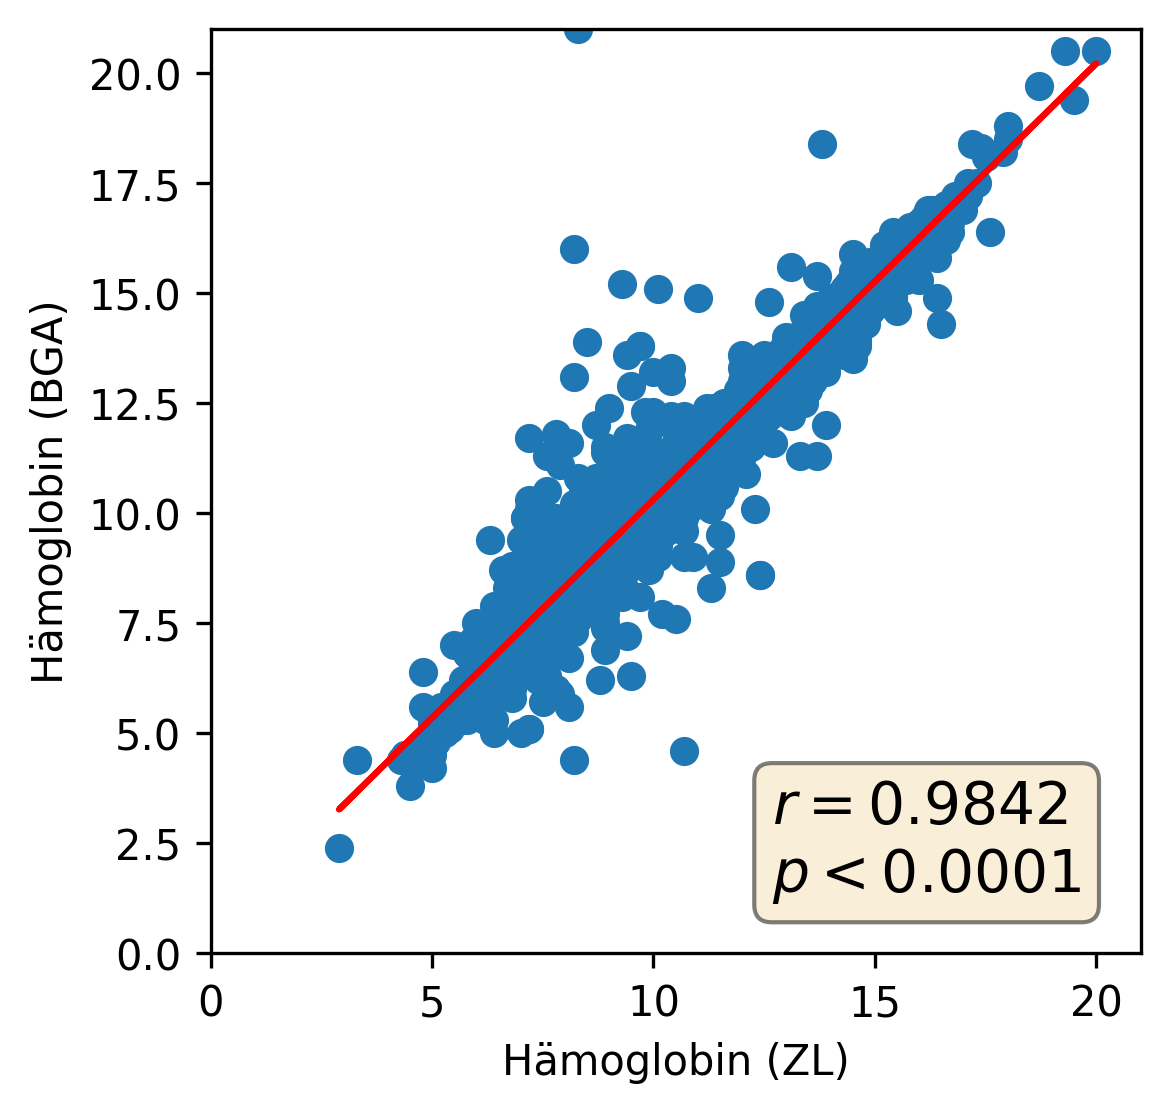

'Done'

In [451]:
def correlation_plot(lab_metadata,total_data,COLNAMES_DICT,top_id,next_id,cor_plot_type):
    top_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == top_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    next_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == next_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]

    df_top = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == top_id]
    df_next = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == next_id]

    df_top.sort_index(inplace=True)
    df_next.sort_index(inplace=True)

    top_sorted_values = df_top[COLNAMES_DICT['VALUE_COL']]
    next_sorted_values = df_next[COLNAMES_DICT['VALUE_COL']]

    corr, p_corr = scipy.stats.pearsonr(top_sorted_values, next_sorted_values)
    plt.figure(figsize=(4, 4), dpi=300)
    plt.scatter(top_sorted_values, next_sorted_values)
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(top_sorted_values, next_sorted_values, 1)

    #use red as color for regression line
    plt.plot(top_sorted_values, m*top_sorted_values+b, color='red')

    p_corr = "<0.0001" if p_corr < 18 else (r'$=%.4f$' % (p_corr, ))


    textstr = '\n'.join((
        r'$r=%.4f$' % (corr, ),
        r'$p%s$' % (p_corr, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    plt.text(0.55, 0.4, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.xlim(0,max(max(top_sorted_values),max(next_sorted_values)))
    plt.xlabel(top_name)
    plt.ylim(0,max(max(top_sorted_values),max(next_sorted_values)))
    plt.ylabel(next_name)
    if(cor_plot_type == 'transformed'):
        plt.savefig(f'correlation_consecutive_transformed_{t_lab_name}.jpg')
    if(cor_plot_type == 'non_transformed'):
        plt.savefig(f'correlation_consecutive_non_transformed_{t_lab_name}.jpg')
    plt.show()
    return('Done')


correlation_plot(lab_metadata,total_data,COLNAMES_DICT,top_id,next_id,'non_trasnformed')

In [472]:
df_adm.head()

subject_id   hadm_id            admittime            dischtime deathtime  \
0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00       NaN   
1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00       NaN   
2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00       NaN   
3    10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00       NaN   
4    10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00       NaN   

   admission_type admit_provider_id      admission_location  \
0          URGENT            P874LG  TRANSFER FROM HOSPITAL   
1        EW EMER.            P09Q6Y          EMERGENCY ROOM   
2        EW EMER.            P60CC5          EMERGENCY ROOM   
3        EW EMER.            P30KEH          EMERGENCY ROOM   
4  EU OBSERVATION            P51VDL          EMERGENCY ROOM   

  discharge_location insurance language marital_status   race  \
0               HOME     Other  ENGLISH        WIDOWED  WHITE   
1               HOME  Medicaid  ENGLISH        WIDOWED  WHITE   
2            HOSPICE  Medicaid  ENGLISH        WIDOWED  WHITE   
3               HOME  Medicaid  ENGLISH        WIDOWED  WHITE   
4                NaN     Other  ENGLISH         SINGLE  WHITE   

             edregtime            edouttime  hospital_expire_flag  
0  2180-05-06 19:17:00  2180-05-06 23:30:00                     0  
1  2180-06-26 15:54:00  2180-06-26 21:31:00                     0  
2  2180-08-05 20:58:00  2180-08-06 01:44:00                     0  
3  2180-07-23 05:54:00  2180-07-23 14:00:00                     0  
4  2160-03-03 21:55:00  2160-03-04 06:26:00                     0

In [494]:
def extract_consecutive_measurement(df_labs_mimic, t_subject_id,t_ids):

    df_pat = df[(df[COLNAMES_DICT['SUBJECT_ID']] == t_subject_id) & df[COLNAMES_DICT['ITEM_ID_COL']].isin(t_ids)]

    df_pat['Offset'] = df_pat['Offset']/60

    # sort patient data in ascending order and filter shifted rows
    asc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)
    asc_sorted = asc_sorted.loc[asc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != asc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

    dsc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=False)
    dsc_sorted = dsc_sorted.loc[dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

    # take only rows from asc_sorted and dsc_sorted to exlude 'intervals' of measurenments with the same item id
    df_pat_sum = df_pat[df_pat[COLNAMES_DICT['ROW_ID']].isin(dsc_sorted[COLNAMES_DICT['ROW_ID']].to_list()+asc_sorted[COLNAMES_DICT['ROW_ID']].to_list())].drop_duplicates()
    df_pat_sum = df_pat_sum.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)

    temp_diff = df_pat_sum[COLNAMES_DICT['TIME_SINCE_AD']].diff()
    df_pat_sum['delta_time'] =  temp_diff.iloc[np.arange(-len(temp_diff)+1,1)].to_list()

    # create col for the next value and item id
    df_pat_sum['next_VALUENUM'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['VALUE_COL']].shift(-1, fill_value='END')
    df_pat_sum['next_ITEMID'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['ITEM_ID_COL']].shift(-1, fill_value='END')

    df_pat_sum['diff_ids'] = df_pat_sum[COLNAMES_DICT['ITEM_ID_COL']] != df_pat_sum['next_ITEMID']

    df_pat_sum = df_pat_sum[df_pat_sum['diff_ids'] == True]

    return(df_pat_sum)

In [ ]:
import itertools
import numpy as np
#list of relevant itemids
item_ids_list = list(itertools.chain.from_iterable((LAB_MAPPING.values()))) 

# Take only relevatn itemids
df_labs_mimic_sub = df_labs_mimic[df_labs_mimic.itemid.isin(item_ids_list)]

#subset of admission table
s_df_adm = df_adm[['hadm_id', 'subject_id','admittime']]
#take first admission per subject_id
s_df_adm = s_df_adm[s_df_adm.groupby('subject_id').admittime.transform('min') == s_df_adm['admittime']]

df_labs_mimic_sub= df_labs_mimic_sub[df_labs_mimic_sub.hadm_id.isin(s_df_adm.hadm_id)]
df_labs_mimic_merged = pd.merge(df_labs_mimic_sub, s_df_adm, on=['hadm_id','subject_id'])

df_labs_mimic_merged['Offset'] = (pd.to_datetime(df_labs_mimic_merged['charttime']) - pd.to_datetime(df_labs_mimic_merged['admittime'])) / np.timedelta64(1, 'h')


In [563]:
df_pat_sum

labevent_id  subject_id     hadm_id  specimen_id  itemid  \
620        32457    10002495  24982426.0     44137555   51222   
626        32499    10002495  24982426.0      3598597   50811   
660        32655    10002495  24982426.0     28059637   51222   

    order_provider_id            charttime            storetime value  \
620               NaN  2141-05-24 06:20:00  2141-05-24 07:32:00  12.2   
626               NaN  2141-05-24 15:07:00  2141-05-24 15:50:00  11.5   
660               NaN  2141-05-29 05:50:00  2141-05-29 07:20:00  11.2   

     valuenum  ... ref_range_upper      flag  priority comments  \
620      12.2  ...            17.5  abnormal      STAT      NaN   
626      11.5  ...            18.0  abnormal       NaN      NaN   
660      11.2  ...            17.5  abnormal      STAT      NaN   

               admittime      Offset delta_time  next_VALUENUM  next_ITEMID  \
620  2141-05-22 20:17:00   34.050000   8.783333           11.5        50811   
626  2141-05-22 20:17:00   42.833333  15.050000           11.1        51222   
660  2141-05-22 20:17:00  153.550000        NaN            END          END   

    diff_ids  
620     True  
626     True  
660     True  

[3 rows x 22 columns]

In [573]:
from tqdm.autonotebook import tqdm
from random import sample

#t_lab_name = 'Hemoglobin' #'Potassium', 'Sodium', 'Bicarbonate'
df = df_labs_mimic_merged.copy()

for t_lab_name in LAB_MAPPING.keys():
    print(t_lab_name)
    t_ids = LAB_MAPPING[t_lab_name]
    subject_ids = df[COLNAMES_DICT['SUBJECT_ID']].unique()
    #subject_ids = sample(subject_ids.tolist(),1000)

    df_lab = extract_consecutive_measurement(df, subject_ids[0],t_ids)

    for t_subject_id in tqdm(subject_ids[1:], mininterval=60):
        t_df_pat_sum = extract_consecutive_measurement(df, t_subject_id,t_ids)
        df_lab = pd.concat([df_lab,t_df_pat_sum])

    df_lab.to_csv(f'mimic_iv_{t_lab_name}_consecutive.csv')

Hemoglobin


  0%|          | 0/138132 [00:00<?, ?it/s]

Hematocrit


  0%|          | 0/138132 [00:00<?, ?it/s]

Glucose


  0%|          | 0/138132 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
def extract_consecutive_measurement(df_labs_mimic, t_subject_id,t_ids):

    df_pat = df[(df[COLNAMES_DICT['SUBJECT_ID']] == t_subject_id) & df[COLNAMES_DICT['ITEM_ID_COL']].isin(t_ids)]

    #df_pat['Offset'] = df_pat['Offset']/60

    # sort patient data in ascending order and filter shifted rows
    asc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)
    asc_sorted = asc_sorted.loc[asc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != asc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

    dsc_sorted = df_pat.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=False)
    dsc_sorted = dsc_sorted.loc[dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']].shift(-1) != dsc_sorted[COLNAMES_DICT['ITEM_ID_COL']]]

    # take only rows from asc_sorted and dsc_sorted to exlude 'intervals' of measurenments with the same item id
    df_pat_sum = df_pat[df_pat[COLNAMES_DICT['ROW_ID']].isin(dsc_sorted[COLNAMES_DICT['ROW_ID']].to_list()+asc_sorted[COLNAMES_DICT['ROW_ID']].to_list())].drop_duplicates()
    df_pat_sum = df_pat_sum.sort_values(by=COLNAMES_DICT['TIME_SINCE_AD'], ascending=True)

    temp_diff = df_pat_sum[COLNAMES_DICT['TIME_SINCE_AD']].diff()
    df_pat_sum['delta_time'] =  temp_diff.iloc[np.arange(-len(temp_diff)+1,1)].to_list()

    # create col for the next value and item id
    df_pat_sum['next_VALUENUM'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['VALUE_COL']].shift(-1, fill_value='END')
    df_pat_sum['next_ITEMID'] = df_pat_sum.groupby(COLNAMES_DICT['SUBJECT_ID'])[COLNAMES_DICT['ITEM_ID_COL']].shift(-1, fill_value='END')

    df_pat_sum['diff_ids'] = df_pat_sum[COLNAMES_DICT['ITEM_ID_COL']] != df_pat_sum['next_ITEMID']

    df_pat_sum = df_pat_sum[df_pat_sum['diff_ids'] == True]

    return(df_pat_sum)

def correlation_plot(lab_metadata,total_data,COLNAMES_DICT,top_id,next_id,cor_plot_type):
    top_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == top_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    next_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == next_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]

    df_top = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == top_id]
    df_next = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == next_id]

    df_top.sort_index(inplace=True)
    df_next.sort_index(inplace=True)

    top_sorted_values = df_top[COLNAMES_DICT['VALUE_COL']]
    next_sorted_values = df_next[COLNAMES_DICT['VALUE_COL']]

    #remove NaN
    top_sorted_values = top_sorted_values[(~top_sorted_values.isna()) & (~next_sorted_values.isna())]
    next_sorted_values = next_sorted_values[(~top_sorted_values.isna()) & (~next_sorted_values.isna())]
    
    corr, p_corr = scipy.stats.pearsonr(top_sorted_values, next_sorted_values)
    plt.figure(figsize=(4, 4), dpi=300)
    plt.scatter(top_sorted_values, next_sorted_values)
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(top_sorted_values, next_sorted_values, 1)

    #use red as color for regression line
    plt.plot(top_sorted_values, m*top_sorted_values+b, color='red')
    
    #p_corr = "{:.2e}".format(p_corr)
    #p_corr = "<0.0001" if p_corr < 18 else (r'$=%.4f$' % (p_corr, ))

    textstr = '\n'.join((
        r'$r=%.4f$' % (corr, ),
        r'$p=%.2e$' % (p_corr, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    # place a text box in upper left in axes coords
    plt.text(max(max(top_sorted_values),max(next_sorted_values))*0.6, max(max(top_sorted_values),max(next_sorted_values))*0.2, textstr, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.xlim(min(min(top_sorted_values),min(next_sorted_values)),max(max(top_sorted_values),max(next_sorted_values)))
    plt.xlabel(top_name)
    plt.ylim(min(min(top_sorted_values),min(next_sorted_values)),max(max(top_sorted_values),max(next_sorted_values)))
    plt.ylabel(next_name)
    if(cor_plot_type == 'transformed'):
        plt.savefig(f'correlation_consecutive_transformed_{t_lab_name}.jpg')
    if(cor_plot_type == 'non_transformed'):
        plt.savefig(f'correlation_consecutive_non_transformed_{t_lab_name}.jpg')
    plt.show()
    
    return(p_corr,corr)

def all_measurements_plot(df,COLNAMES_DICT, FEATURE_NAME,plot_type,top_id,next_id, max_int=None):
    top_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == top_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    next_name = lab_metadata[lab_metadata[COLNAMES_DICT['METADATA_ITEM_ID_COL']] == next_id][COLNAMES_DICT['METADATA_NAME_COL']].iloc[0]
    
    df  = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id, next_id])]
    
    df[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df[COLNAMES_DICT['VALUE_COL']])
        
    if(plot_type == 'first'):
        df  = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id, next_id])].groupby([COLNAMES_DICT['SUBJECT_ID'],COLNAMES_DICT['ITEM_ID_COL']]).first().reset_index()

    if((plot_type == 'first') | (plot_type == 'all')):
        p_val = stats.ttest_ind(pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']]),
                                pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']]))[1]
        text_p_val = "{:.2e}".format(p_val)
    if((plot_type == 'consecutive') | (plot_type == 'consecutive_transformed')):
        p_val = stats.ttest_rel(pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']]),
                                pd.to_numeric(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']]))[1]
        text_p_val = "{:.2e}".format(p_val)
        
    max_xlim = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin([top_id,next_id])][COLNAMES_DICT['VALUE_COL']].mean()*3
    min_xlim = 0
    if (round(max_xlim,0) == 0): #data was standerdized
        max_xlim = 5
        min_xlim = -5
    fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == top_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="b", label=top_name)
    fig = sns.kdeplot(df[df[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']], shade=True, color="r", label=next_name)
    if(plot_type == 'first'):
        plt.title(f'First measurement per subject, P-Value = {text_p_val}')
    if(plot_type == 'all'):
        plt.title(f'All measurements, P-Value = {text_p_val}')
    if(plot_type == 'consecutive'):
        plt.title(f'Consecutive measurements [{max_int}min], P-Value = {text_p_val}, [N = {int(len(df)/2):,}]')
    if(plot_type == 'consecutive_transformed'):
        plt.title(f'Consecutive transformed measurements [{max_int}min], P-Value = {text_p_val}, [N = {int(len(df)/2):,}]')

    plt.xlim(min_xlim,max_xlim)
    plt.xlabel(FEATURE_NAME)

    plt.legend()        
    if(plot_type == 'first'):
        plt.savefig(f'{FEATURE_NAME}_first_measurements.jpg')
    if(plot_type == 'all'):
        plt.savefig(f'{FEATURE_NAME}_all_measurements.jpg')
    if(plot_type == 'consecutive'):
        plt.savefig(f'{FEATURE_NAME}_consecutive_{max_int}min.jpg')
    if(plot_type == 'consecutive_transformed'):
        plt.savefig(f'{FEATURE_NAME}_consecutive_transformed_{max_int}min.jpg')

    plt.show()

    return(p_val)


def box_cox_transform(total_data,top_id,next_id,COLNAMES_DICT):
    df_top = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == top_id]
    df_next = total_data[total_data[COLNAMES_DICT['ITEM_ID_COL']] == next_id]

    df_top_box, top_box_lambda = stats.boxcox(df_top[COLNAMES_DICT['VALUE_COL']])
    df_next_box, next_box_lambda = stats.boxcox(df_next[COLNAMES_DICT['VALUE_COL']])

    mu_top = df_top_box.mean()
    sig_top = df_top_box.std()

    total_data_box = total_data.copy()
    #total_data_box.loc[total_data_box[COLNAMES_DICT['ITEM_ID_COL']] == top_id, COLNAMES_DICT['VALUE_COL']] = df_top_box
    total_data_box.loc[total_data_box[COLNAMES_DICT['ITEM_ID_COL']] == next_id, COLNAMES_DICT['VALUE_COL']] = inv_boxcox(((stats.zscore(df_next_box))*(sig_top))+mu_top,top_box_lambda)
    
    return(top_box_lambda,mu_top,sig_top, total_data_box)


def invert_dict(input_dict):
    """ Gets a dict that has list values.
        Converts them to a format where each item on the list is a key, and the original key is the value.
        {"key":["a","b"]} -> {"a": "key", "b": "key"}
    """
    output_dict = {}
    for key, val_list in input_dict.items():
        for feat_to_rename in val_list:
            output_dict[feat_to_rename] = key

    return output_dict

def box_cox_transform_train_test(X_train, X_test, COLNAMES_DICT,max_int,top_id,next_id,t_lab_name):
    train_ids = X_train[COLNAMES_DICT['SUBJECT_ID']].unique()

    # load conssecutive measurements
    df_lab = pd.read_csv(f'sicdb_{t_lab_name}_consecutive.csv', index_col=[0])

    # take only ids in train
    df_lab_train = df_lab[df_lab[COLNAMES_DICT['SUBJECT_ID']].isin(train_ids)]

    # remove last rows per patient
    df_lab_train = df_lab_train[(df_lab_train['next_VALUENUM'] != 'END') & (df_lab_train[COLNAMES_DICT['VALUE_COL']] != 'END')]

    # covnvert values to numeric values
    df_lab_train['next_VALUENUM'] = pd.to_numeric(df_lab_train['next_VALUENUM'])
    df_lab_train[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df_lab_train[COLNAMES_DICT['VALUE_COL']])

    #exclude inhuman values
    df_lab_train = df_lab_train[(df_lab_train[COLNAMES_DICT['VALUE_COL']] >0) & (df_lab_train['next_VALUENUM'] >0)]
    df_lab_train = df_lab_train[(df_lab_train[COLNAMES_DICT['VALUE_COL']] <1000) & (df_lab_train['next_VALUENUM'] <1000)]

    # Exlude nan values
    df_lab_train = df_lab_train[(~df_lab_train[COLNAMES_DICT['VALUE_COL']].isna()) & (~df_lab_train.next_VALUENUM.isna())]

    # Take only subset with consecutive measurements lower than max-int
    df_lab_train = df_lab_train[df_lab_train.delta_time < max_int]

    next_values = df_lab_train[['next_ITEMID','next_VALUENUM']].rename(columns={"next_ITEMID": COLNAMES_DICT['ITEM_ID_COL'], "next_VALUENUM": COLNAMES_DICT['VALUE_COL']})
    current_values =  df_lab_train[[COLNAMES_DICT['ITEM_ID_COL'],COLNAMES_DICT['VALUE_COL']]]

    total_data = pd.concat([current_values,next_values],axis =0)
    total_data.LaboratoryID = pd.to_numeric(total_data.LaboratoryID)

    # Learn boxcox transformation based on conssecutive measurements
    top_box_lambda,mu_top,sig_top, total_data_boxcox = box_cox_transform(total_data,top_id,next_id,COLNAMES_DICT)

    # Convert next_id to normal distribution using train data
    X_train_next_box, train_next_box_lambda = stats.boxcox(X_train[X_train[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']])

    # Using  the learned train_next_box_lambda, convert the test set
    X_test_next_box = stats.boxcox(X_test[X_test[COLNAMES_DICT['ITEM_ID_COL']] == next_id][COLNAMES_DICT['VALUE_COL']],train_next_box_lambda)

    # Transform data to normal distribution
    X_train_next_box_trasnformed = inv_boxcox(((stats.zscore(X_train_next_box))*(sig_top))+mu_top,top_box_lambda)
    X_test_next_box_trasnformed = inv_boxcox(((stats.zscore(X_test_next_box))*(sig_top))+mu_top,top_box_lambda)
    
    # assign tranformed values
    X_train.loc[(X_train[COLNAMES_DICT['ITEM_ID_COL']] == next_id), COLNAMES_DICT['VALUE_COL']] = X_train_next_box_trasnformed
    X_test.loc[(X_test[COLNAMES_DICT['ITEM_ID_COL']] == next_id), COLNAMES_DICT['VALUE_COL']] = X_test_next_box_trasnformed

    return(X_train, X_test)

In [18]:
t_lab_name

'Hemoglobin'

In [27]:
#MIMIC_IV
LAB_MAPPING = {
    'Hemoglobin': [51222, 50811],
    'Hematocrit': [51221, 50810],
    #'PH':[663,688], #697 - 15,703 rows
    #'PO2':[689,664], #694 - 15,665 rows
    'Glucose':[50931,50809],
    #'Lactate':[657, 465],
    'Bicarbonate':[50882,50803],
    'Chlorid':[50902, 50806],
    'Potassium':[50971,50822],
    'Sodium':[50983,50824]}

COLNAMES_DICT = {'VALUE_COL':'valuenum',
                 'ITEM_ID_COL':'itemid',
                 'METADATA_ITEM_ID_COL':'itemid',
                 'METADATA_NAME_COL':'label',
                 'SUBJECT_ID':'subject_id',
                 'TIME_SINCE_AD': 'Offset', #hours
                 'ROW_ID': 'labevent_id'}

In [37]:
df = df_labs_mimic.copy()

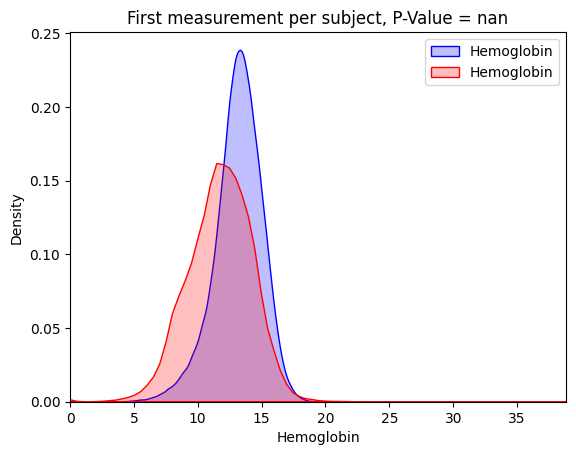

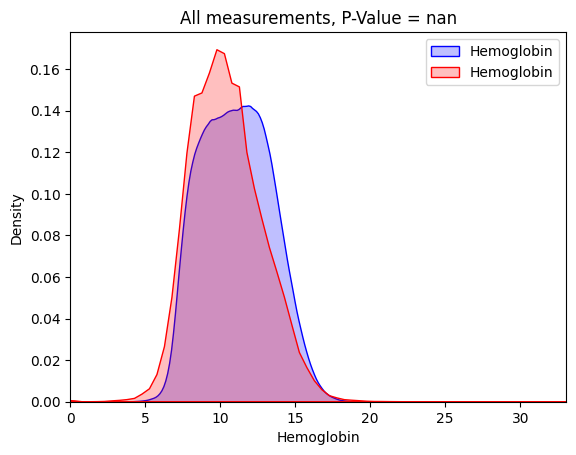

Feature:Hemoglobin, T=5


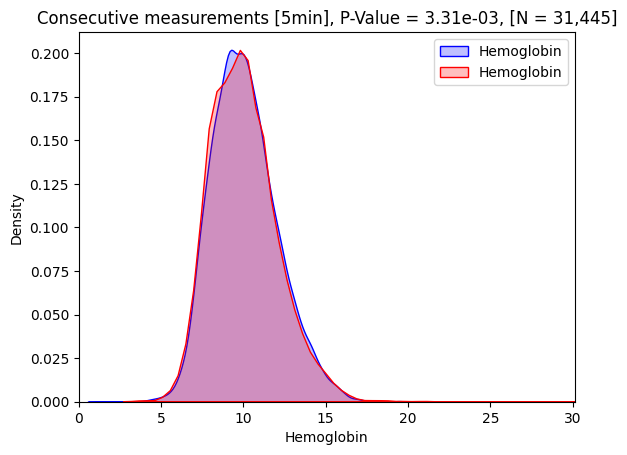

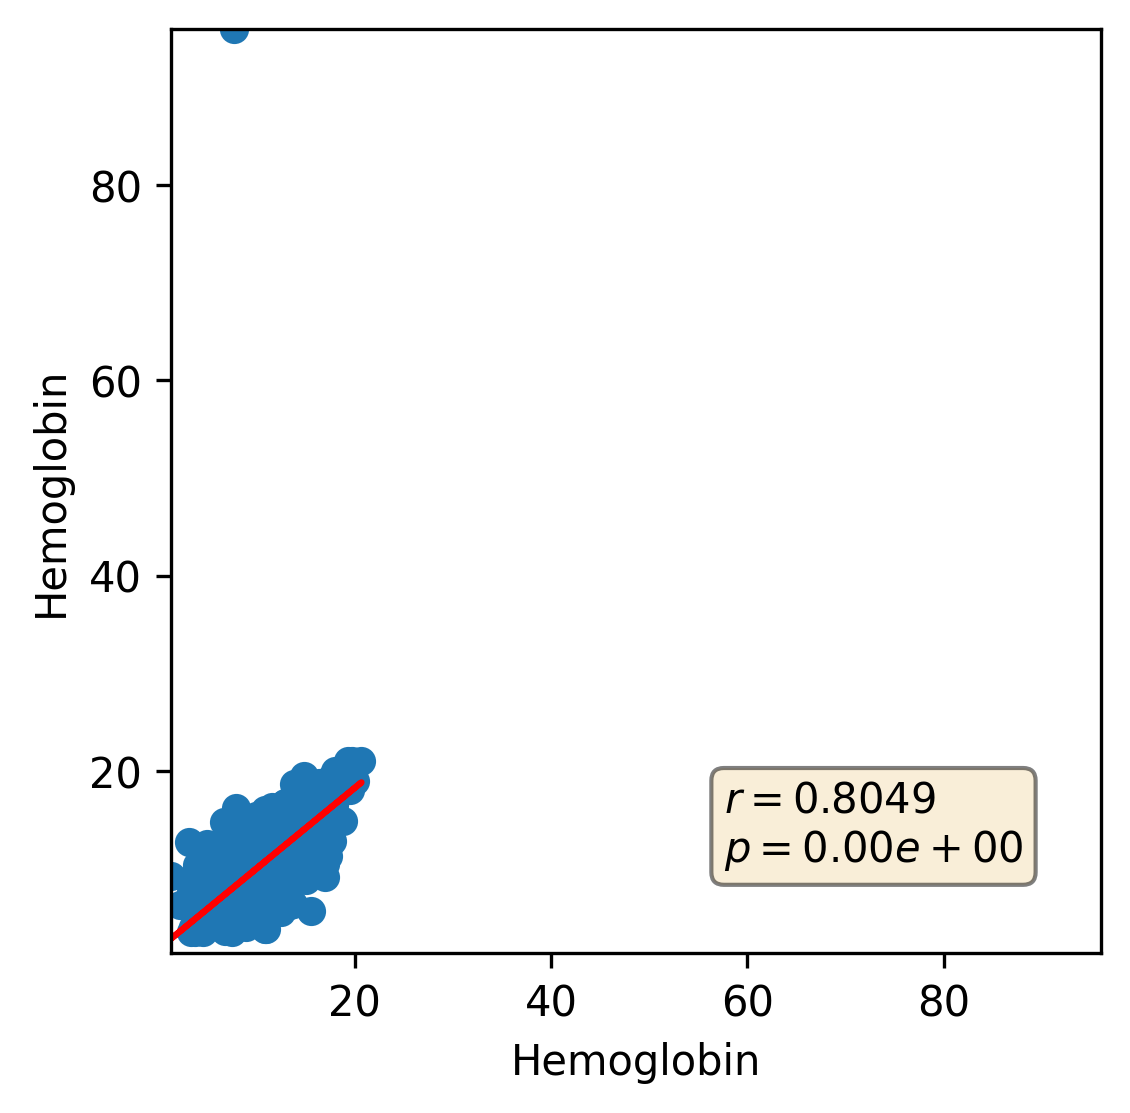

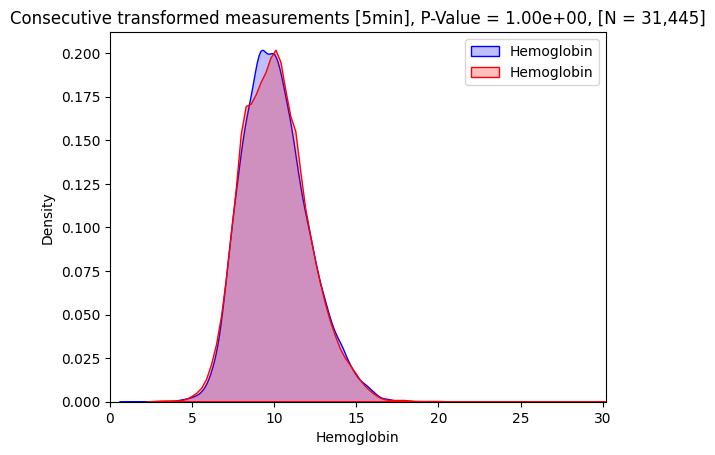

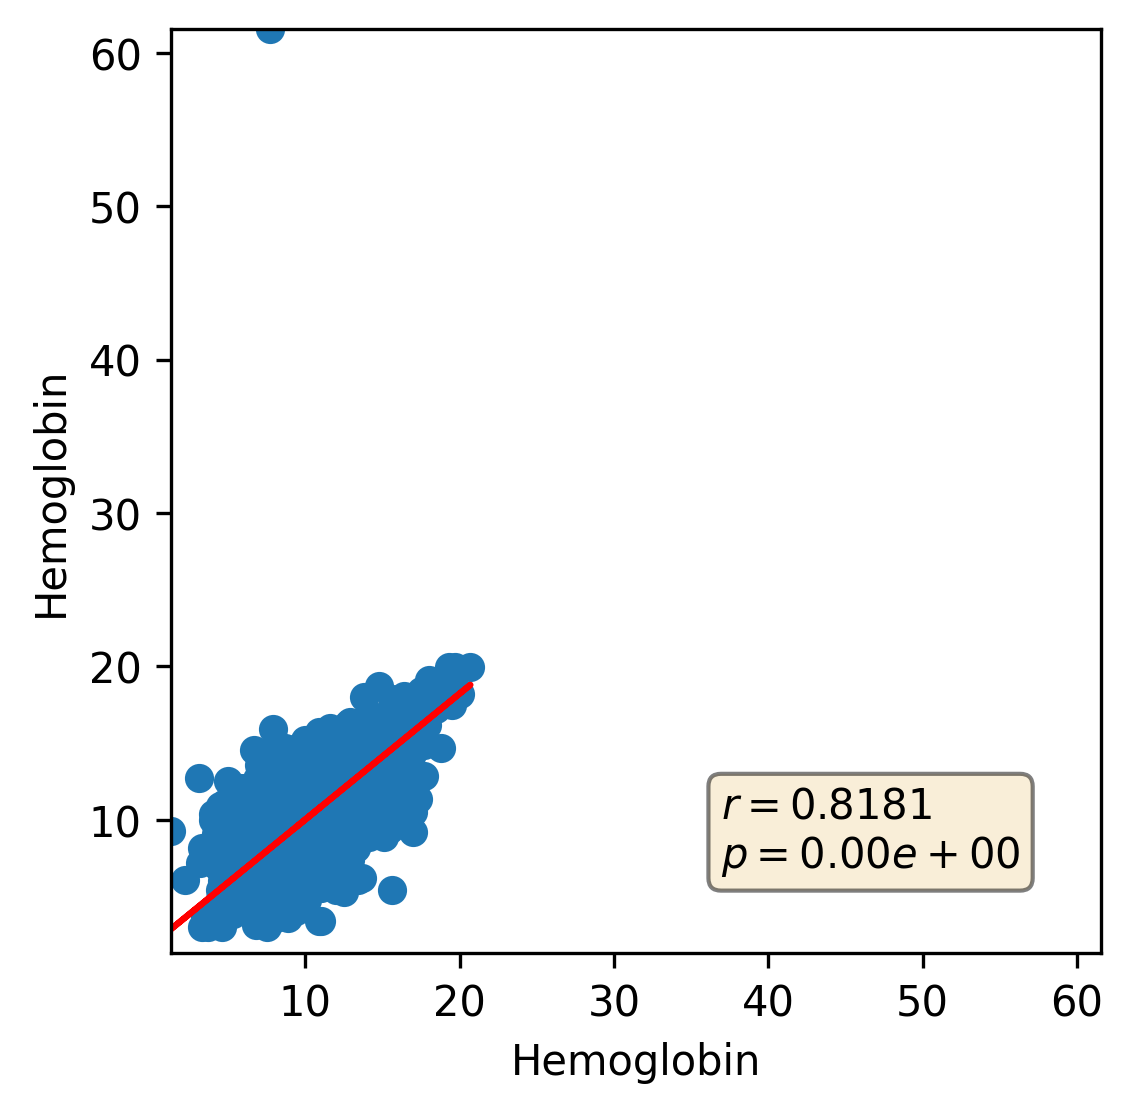

Feature:Hemoglobin, T=10


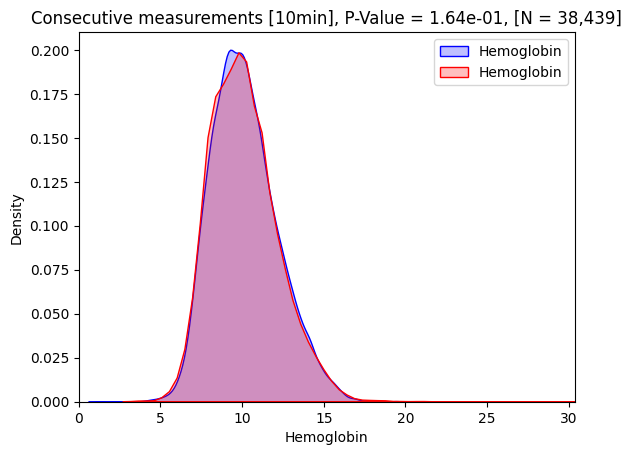

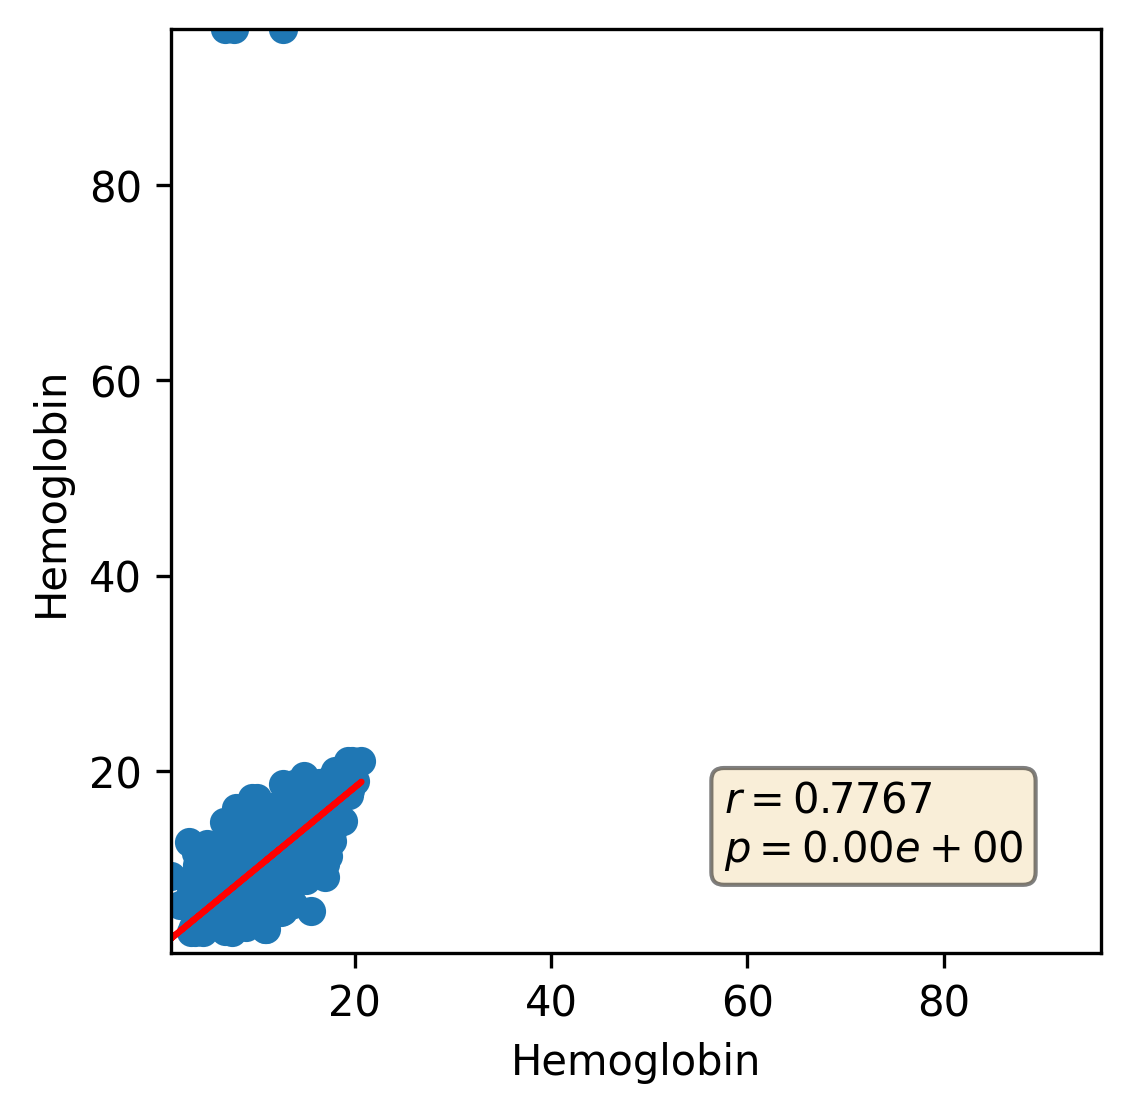

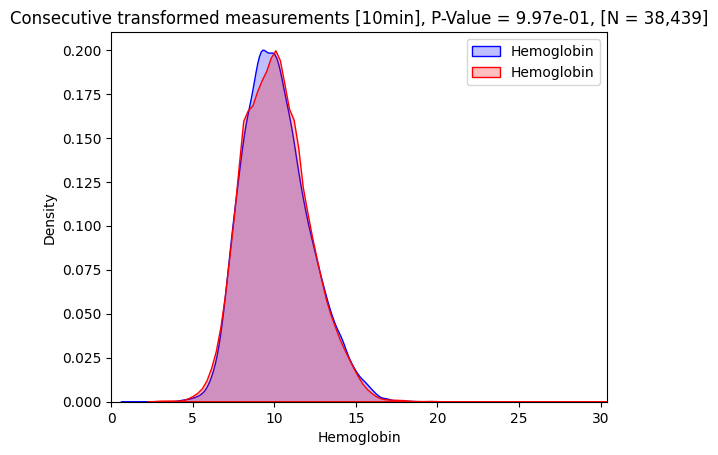

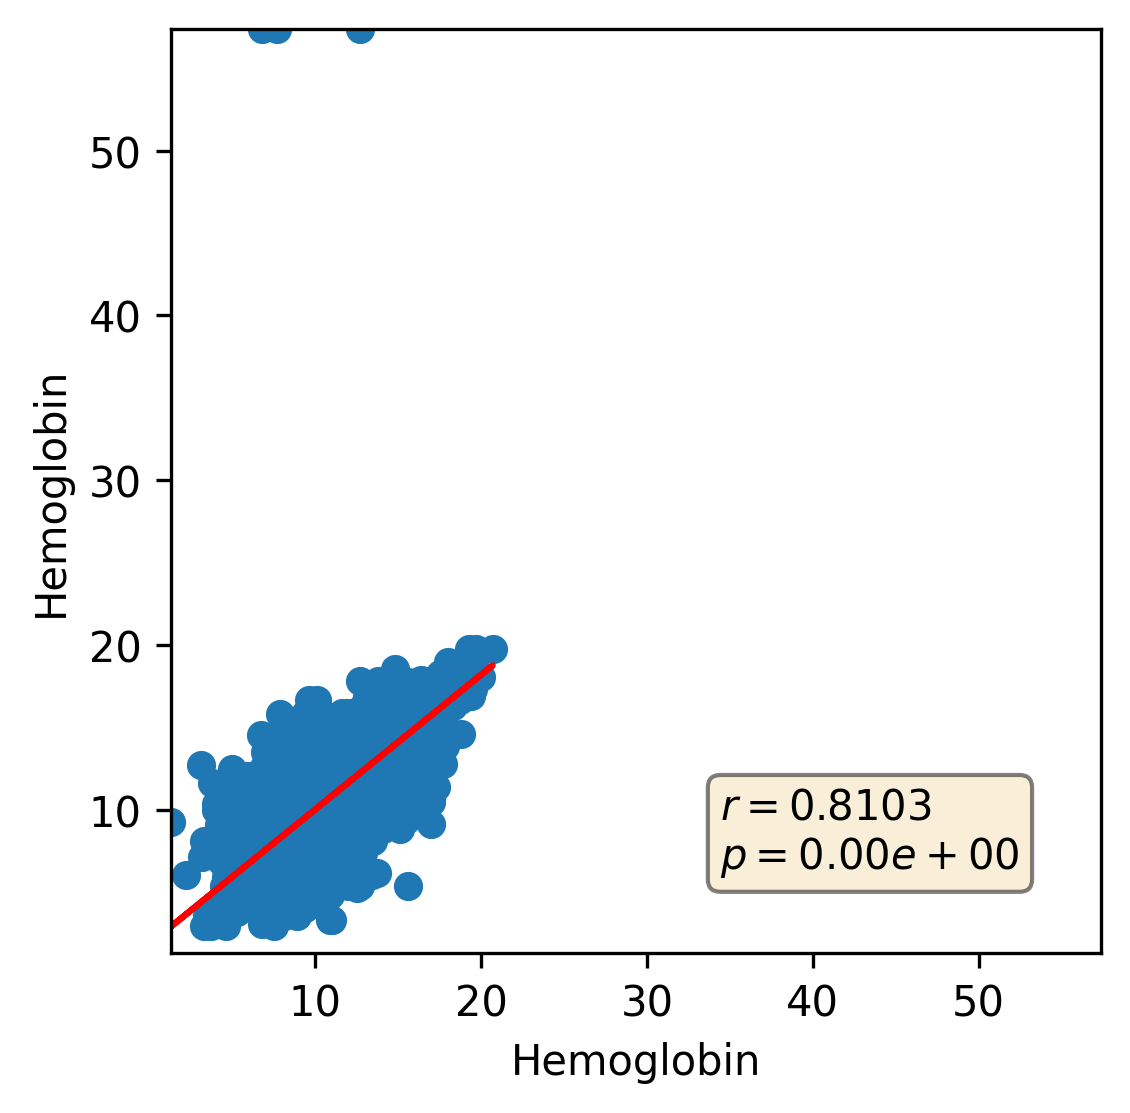

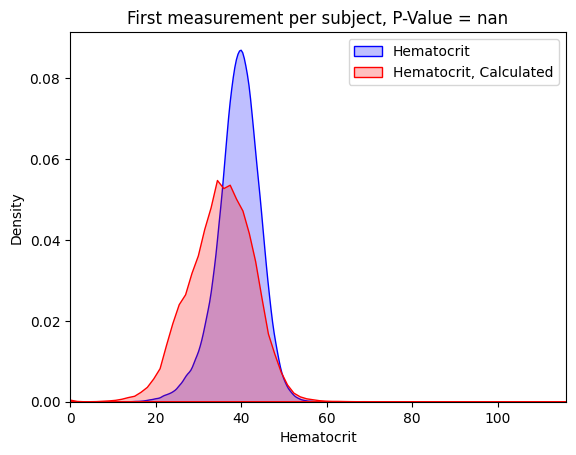

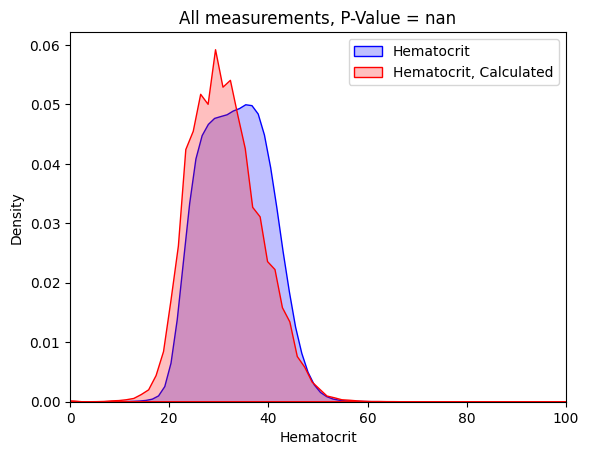

Feature:Hematocrit, T=5


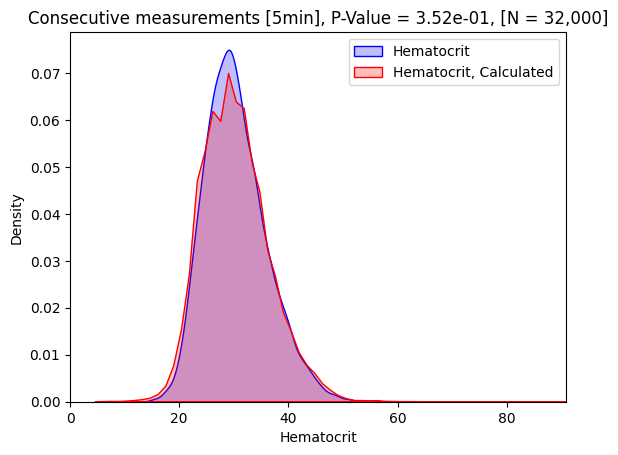

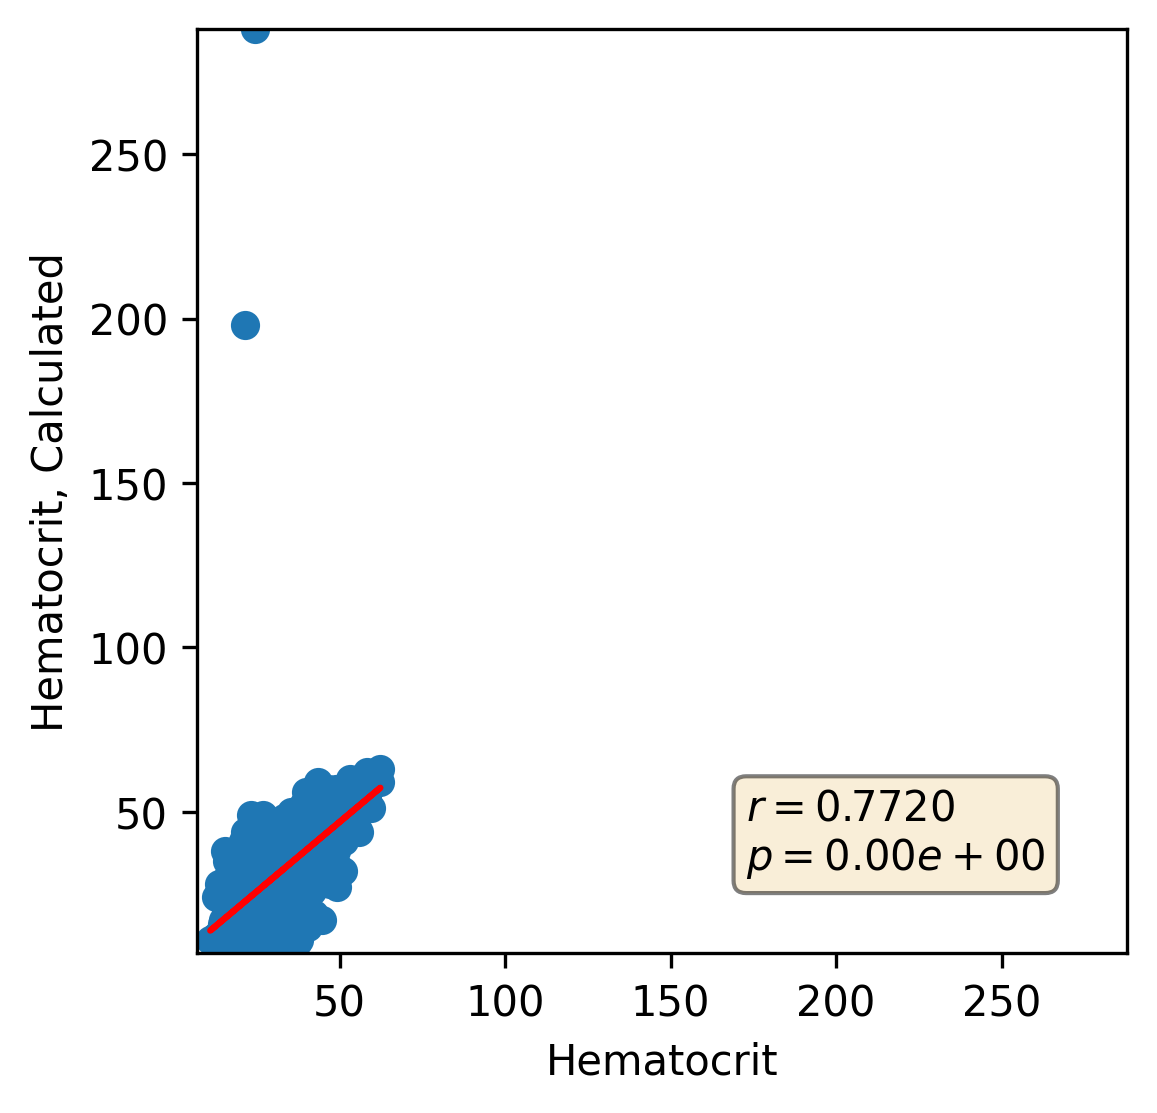

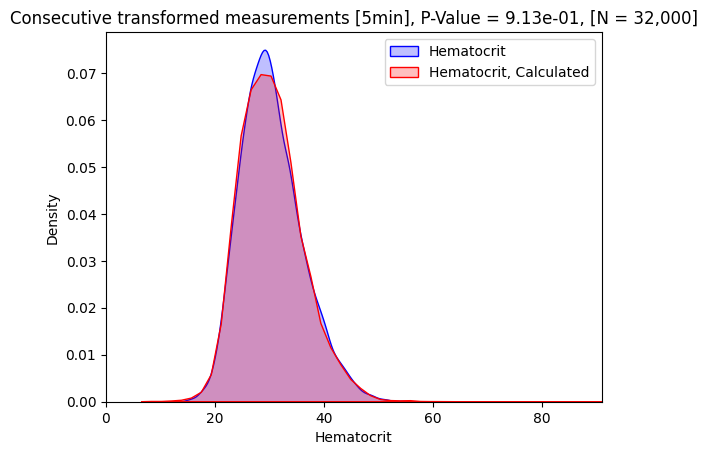

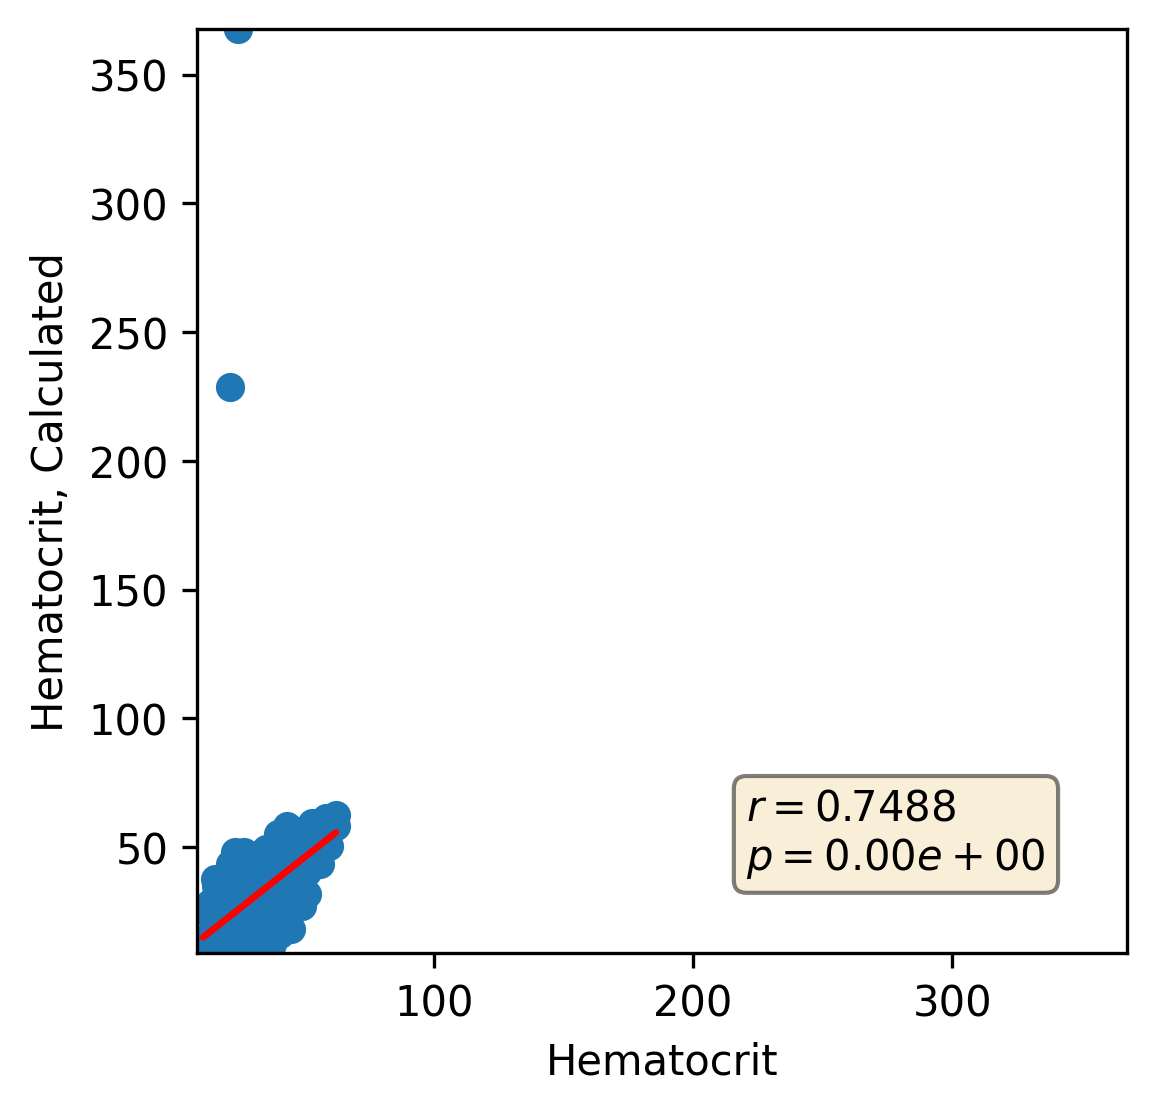

Feature:Hematocrit, T=10


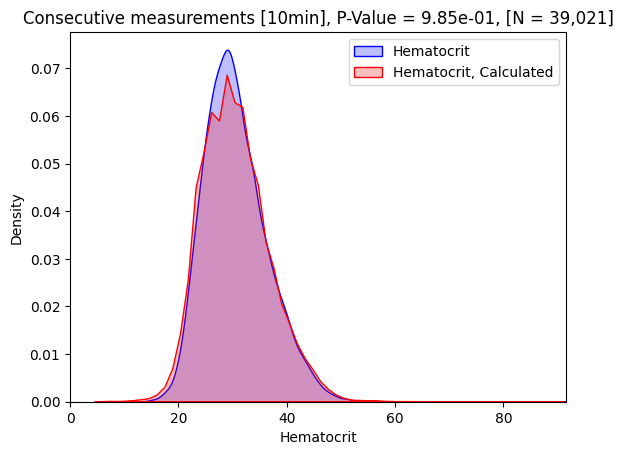

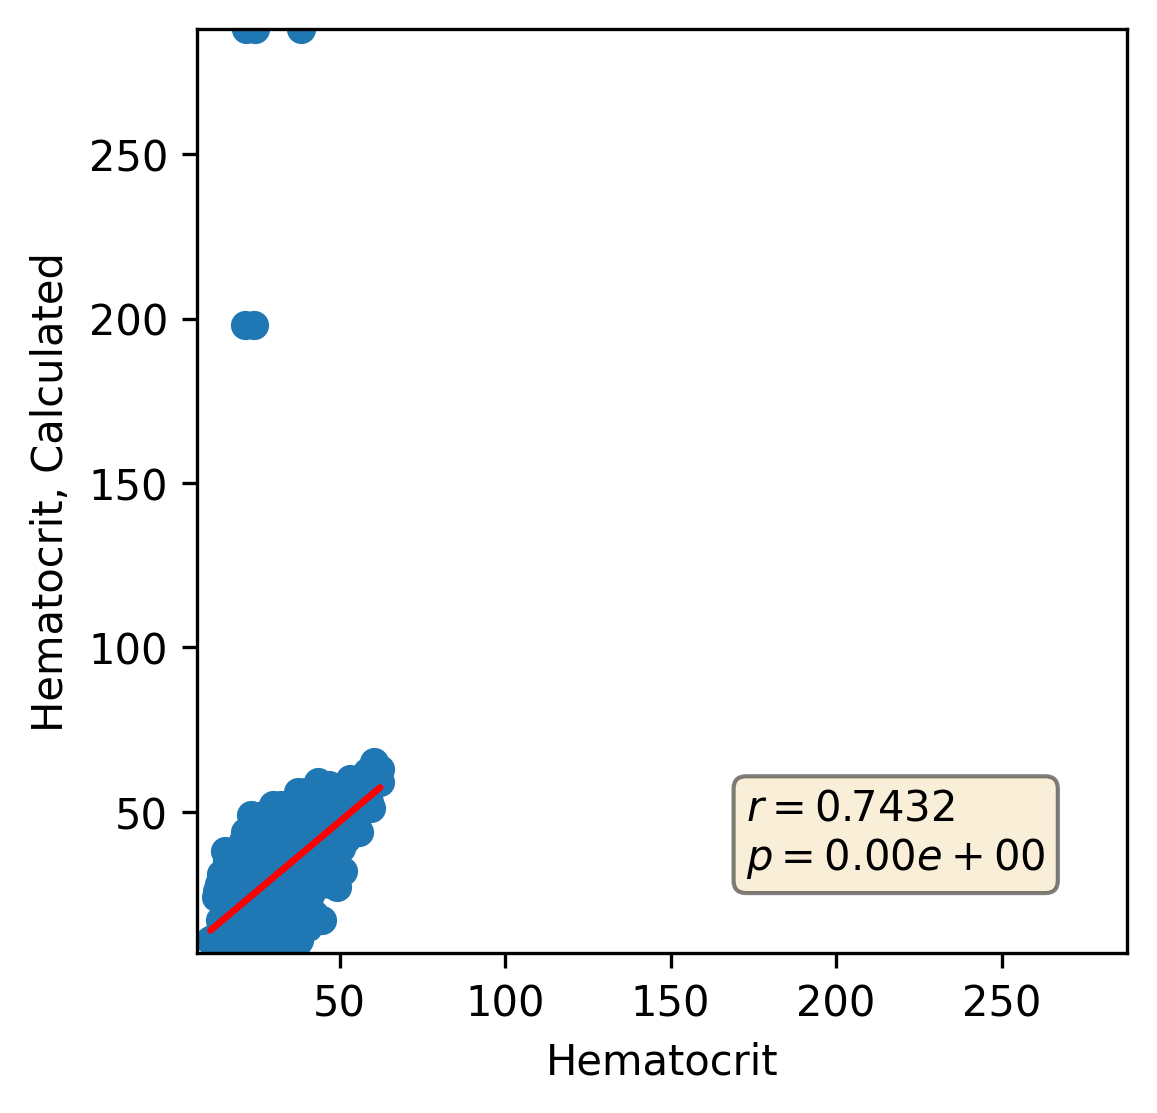

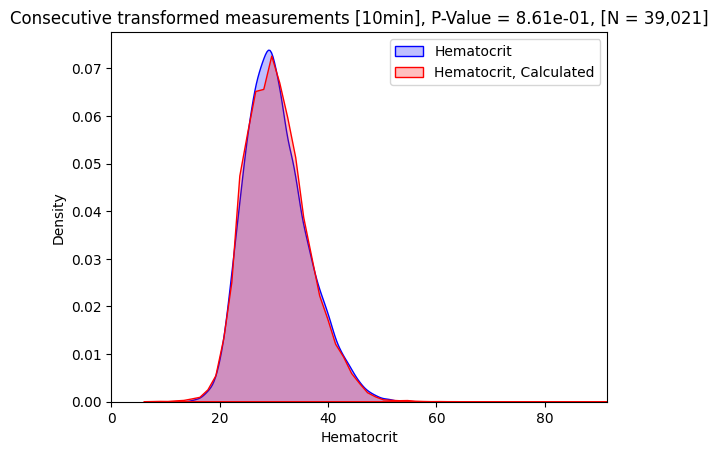

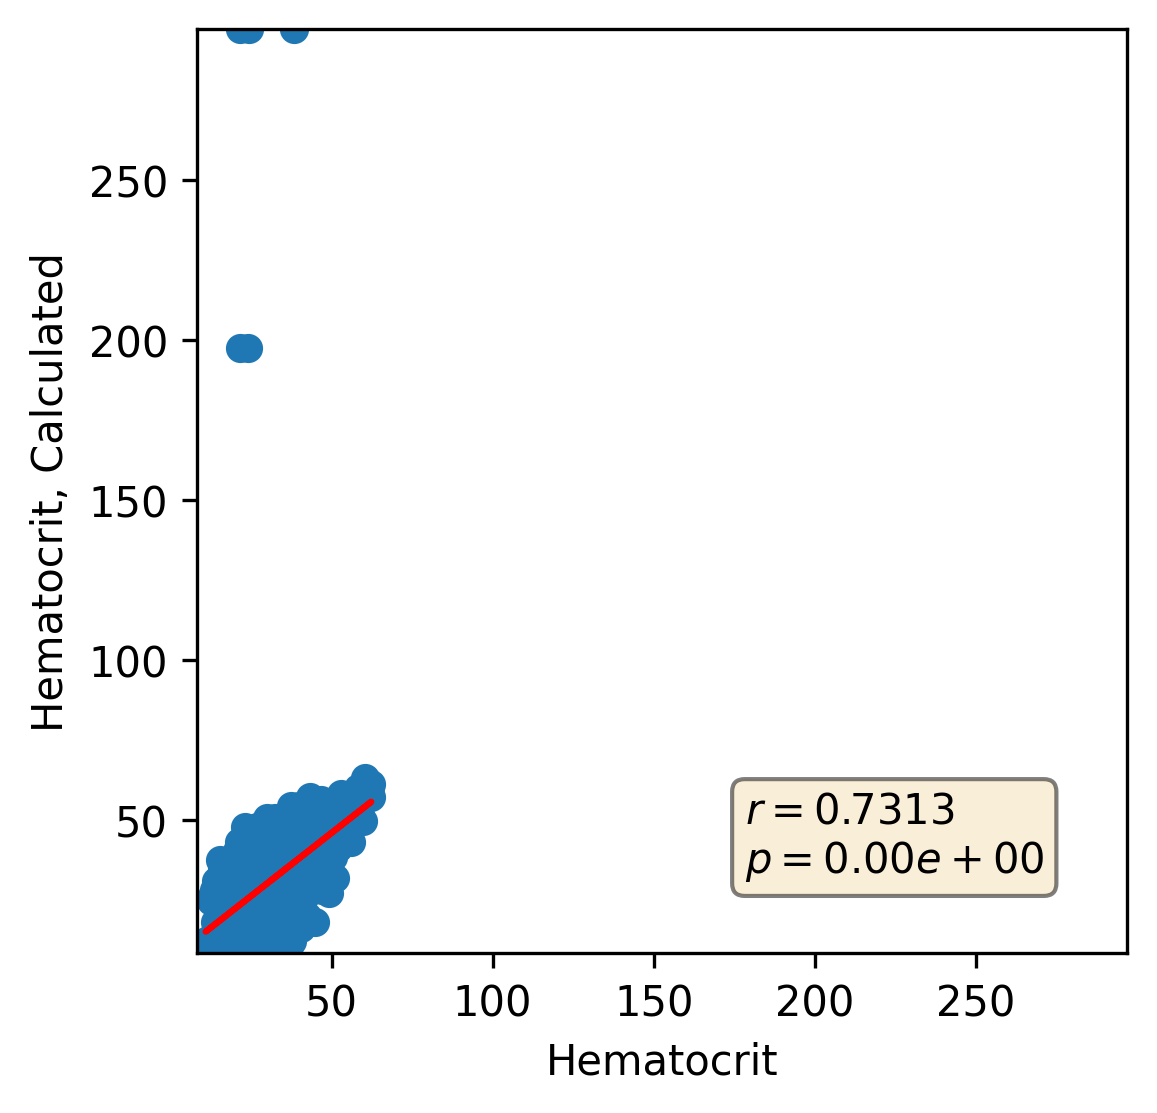

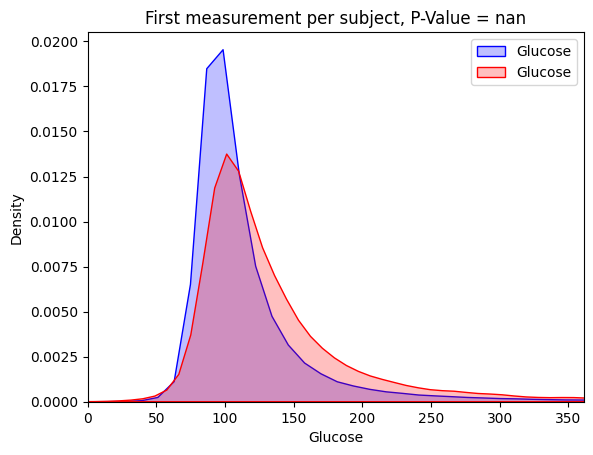

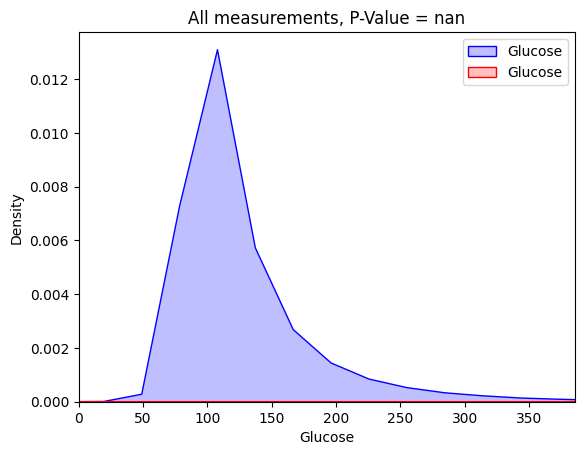

Feature:Glucose, T=5


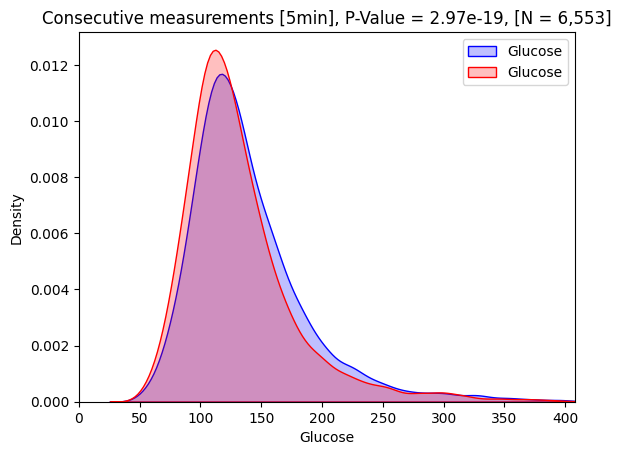

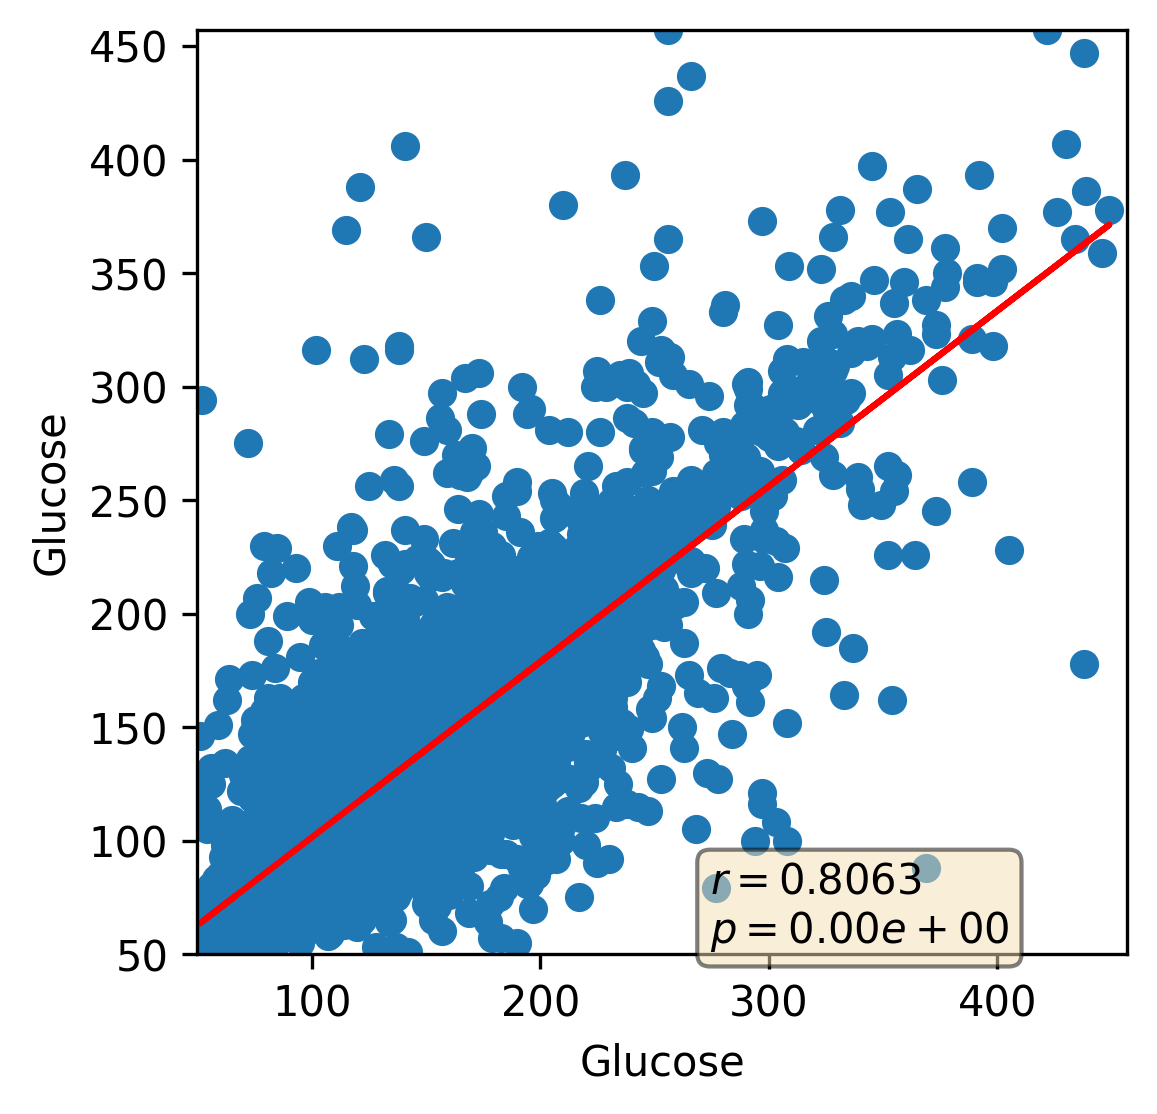

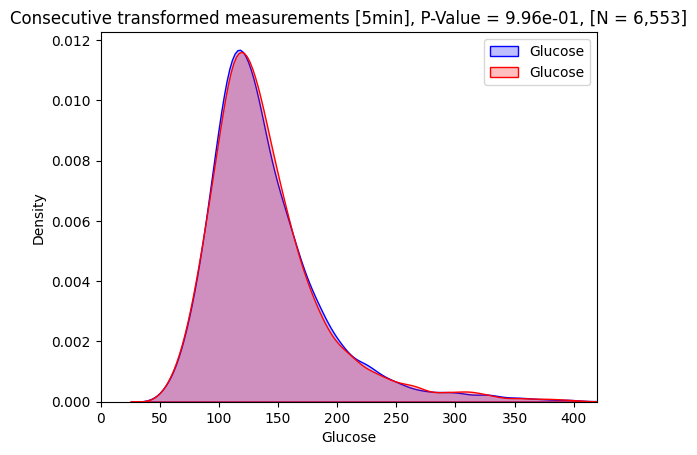

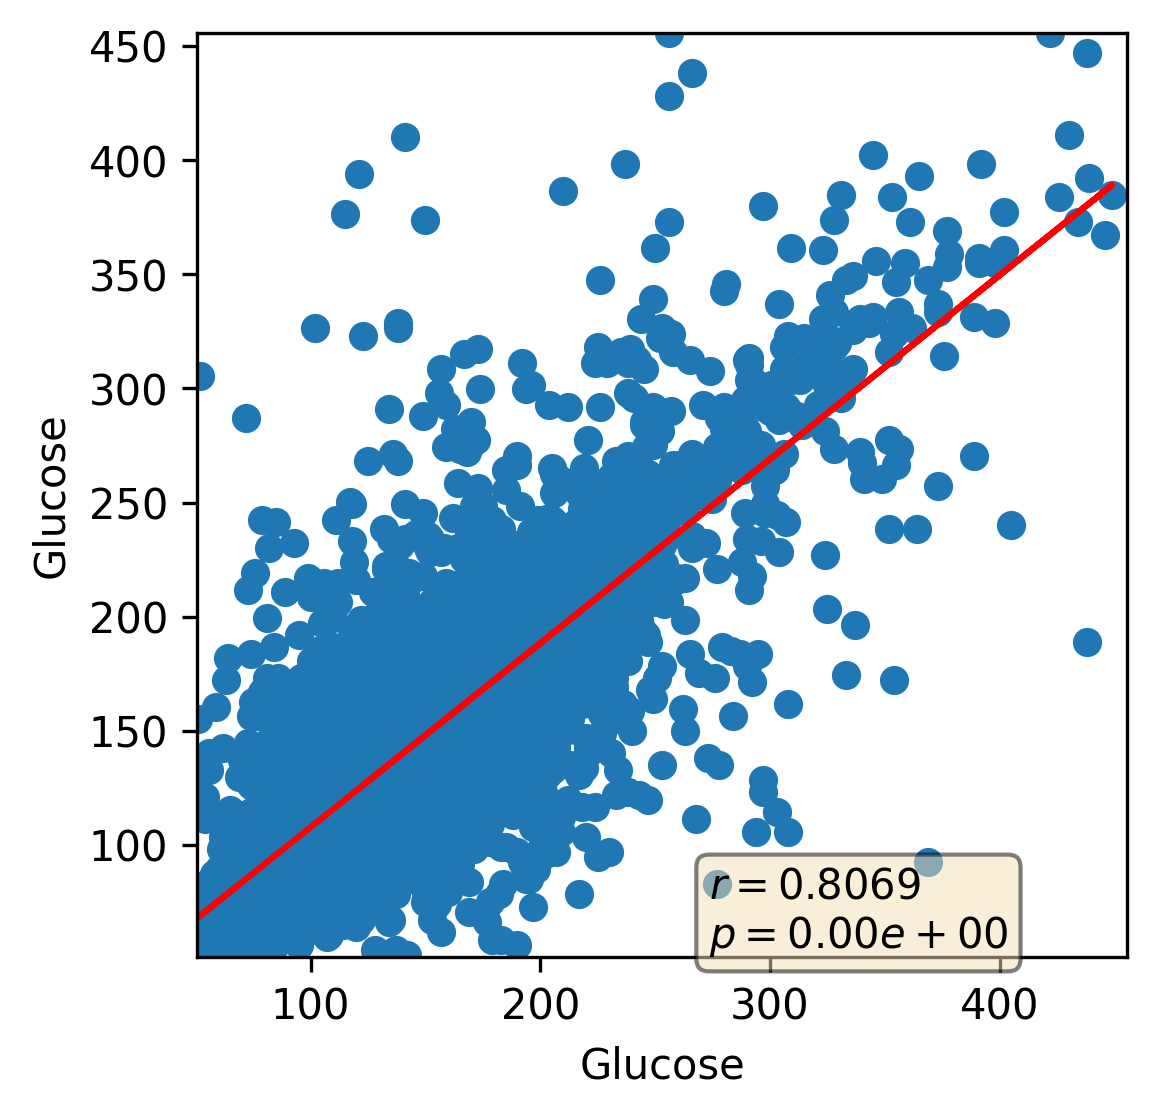

Feature:Glucose, T=10


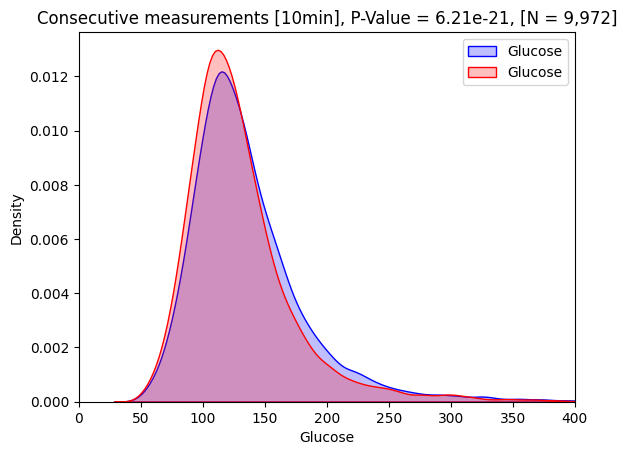

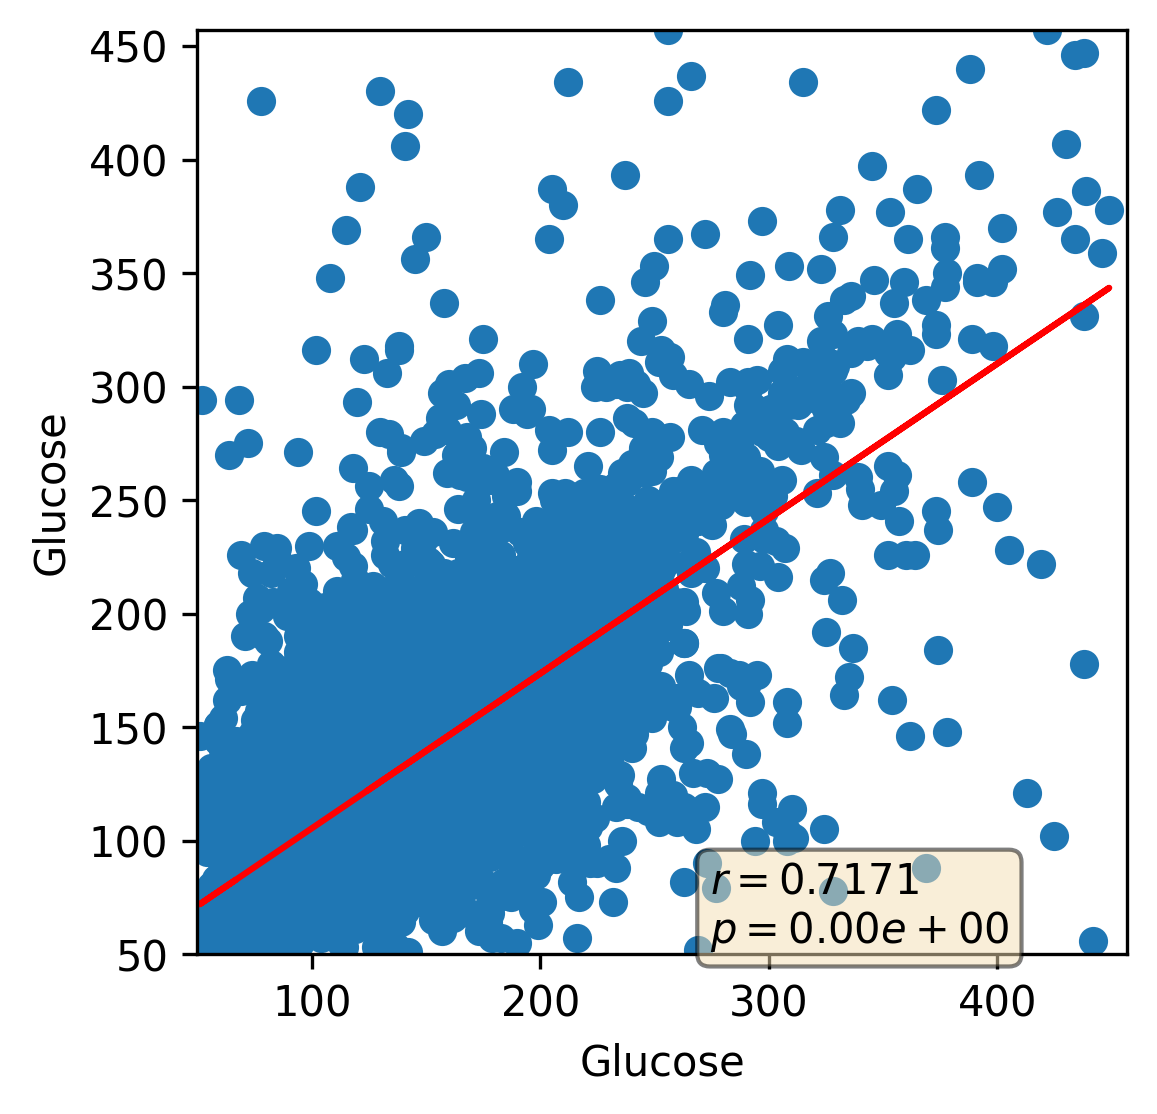

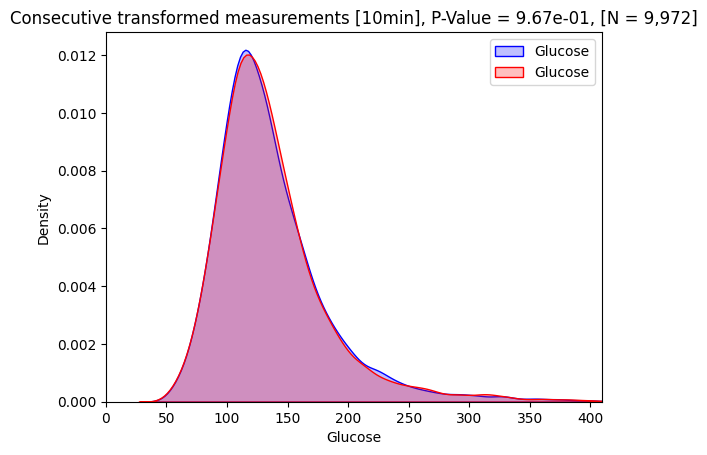

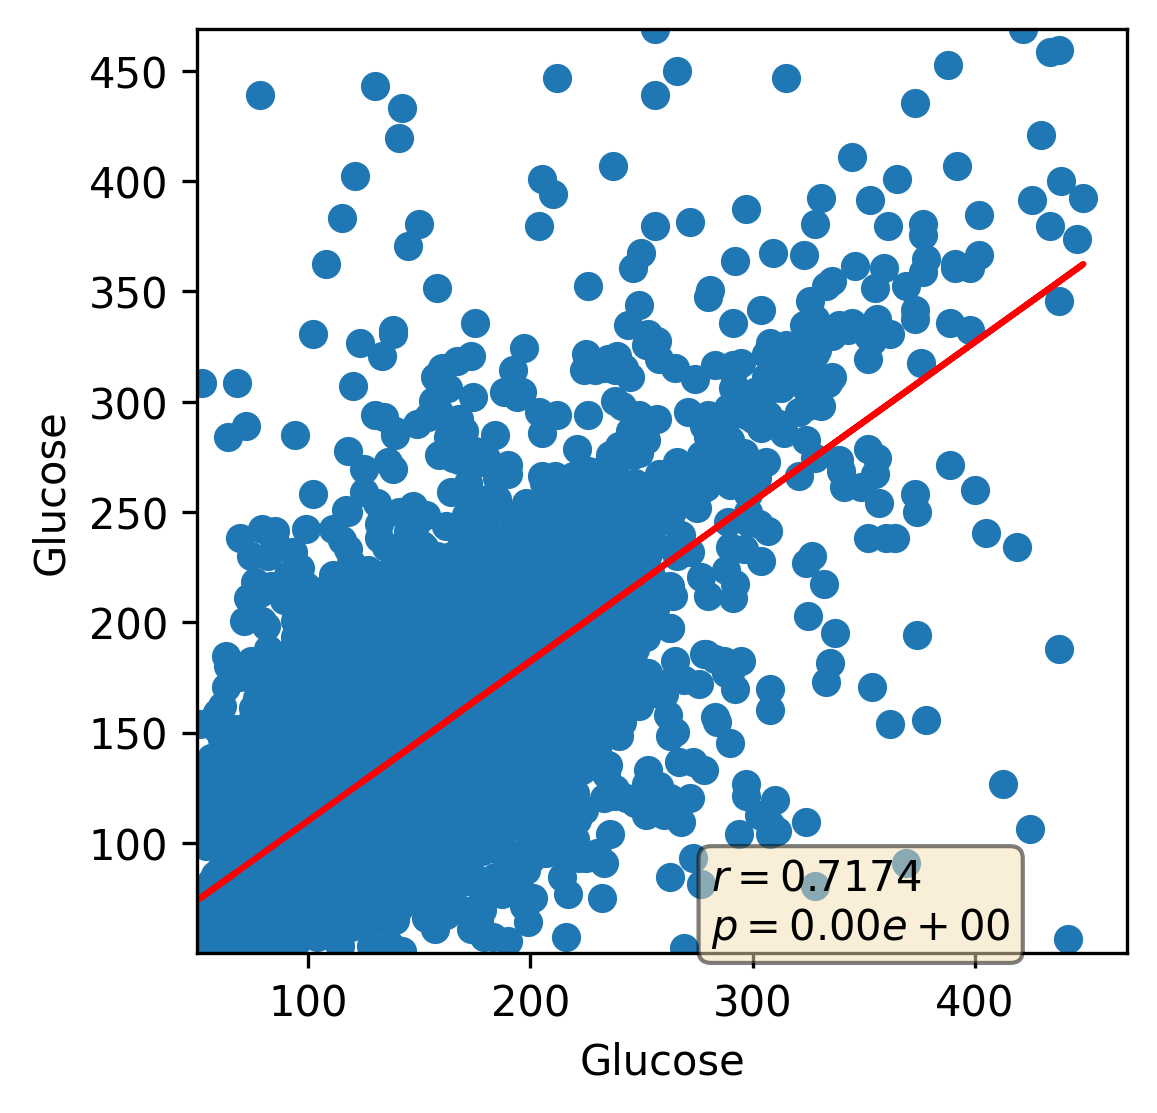

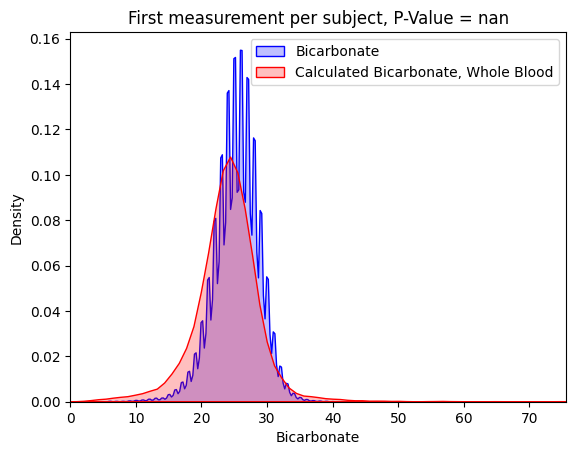

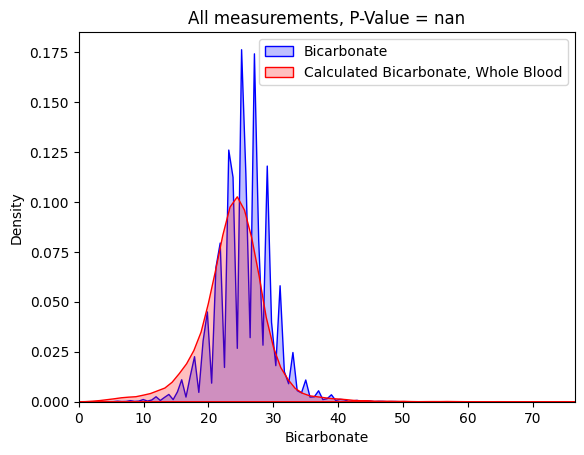

Feature:Bicarbonate, T=5


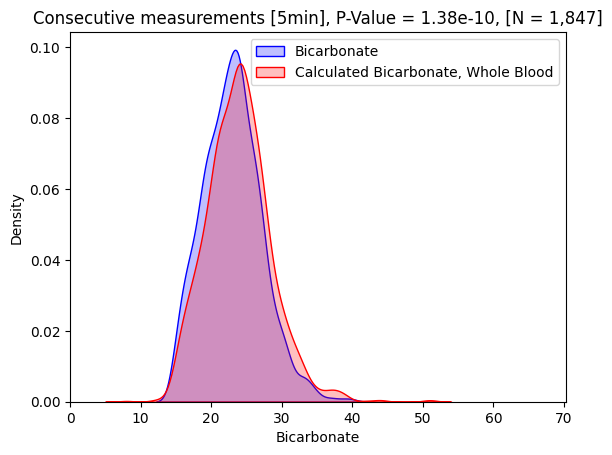

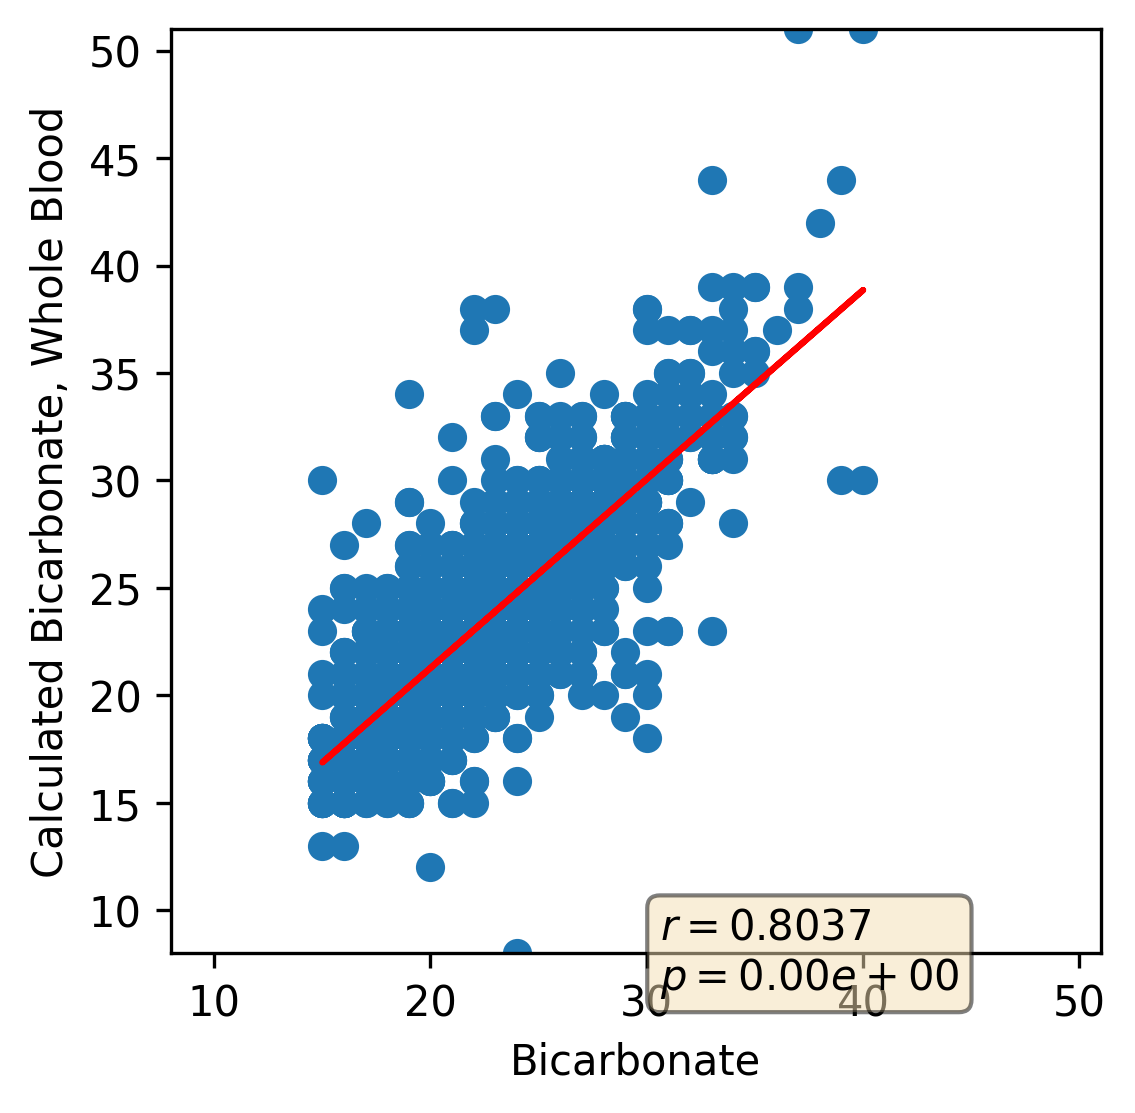

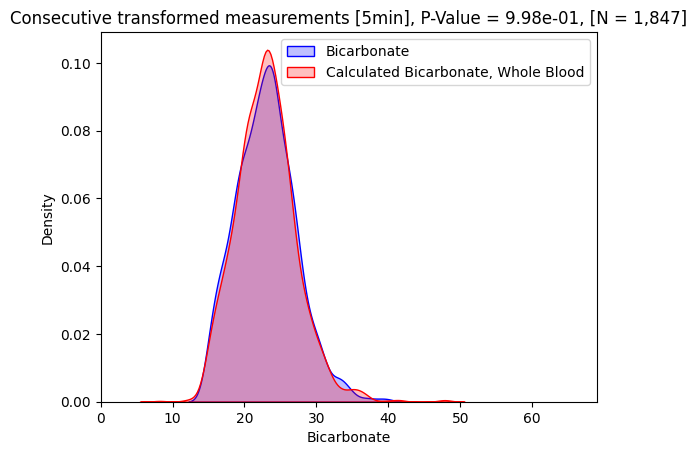

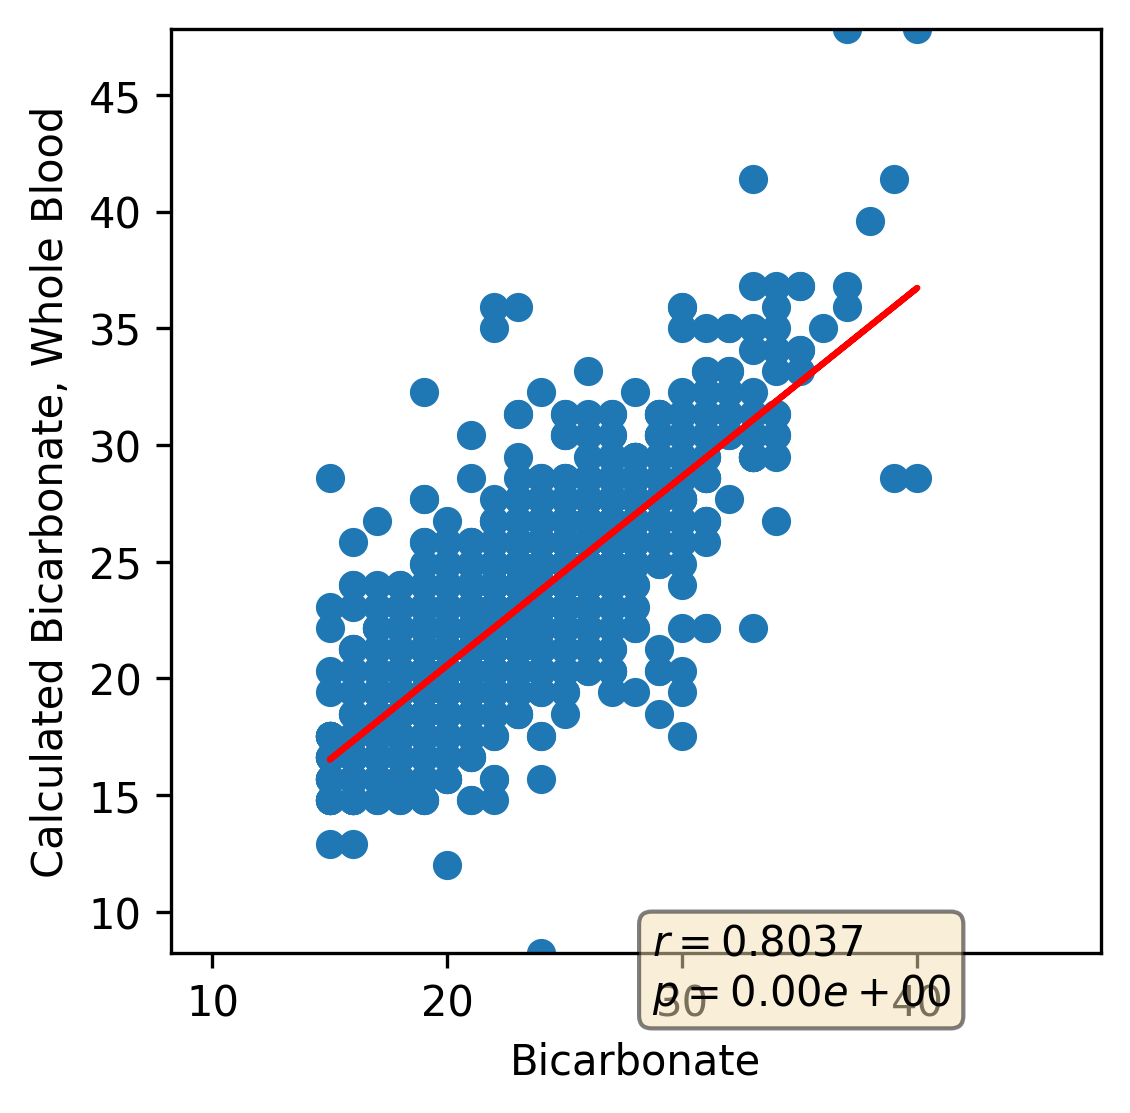

Feature:Bicarbonate, T=10


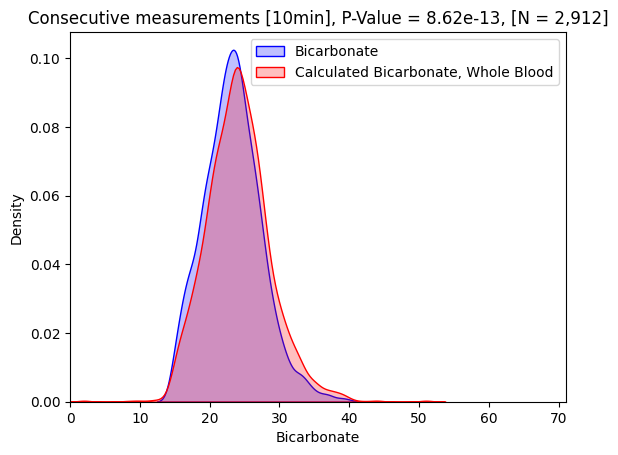

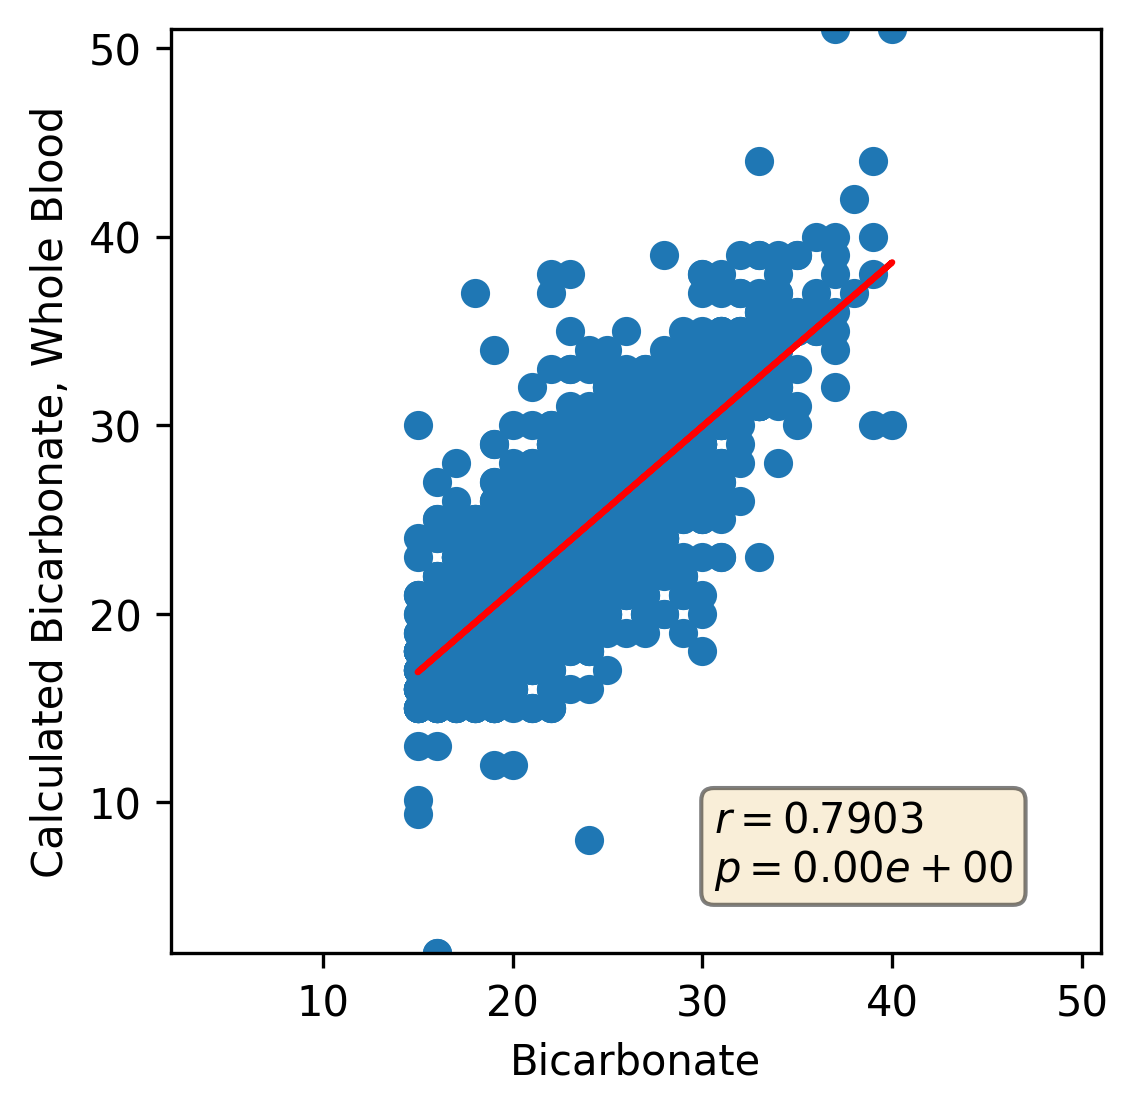

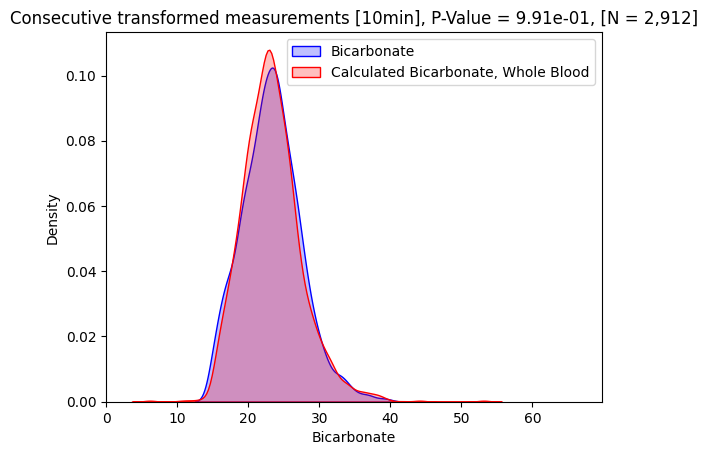

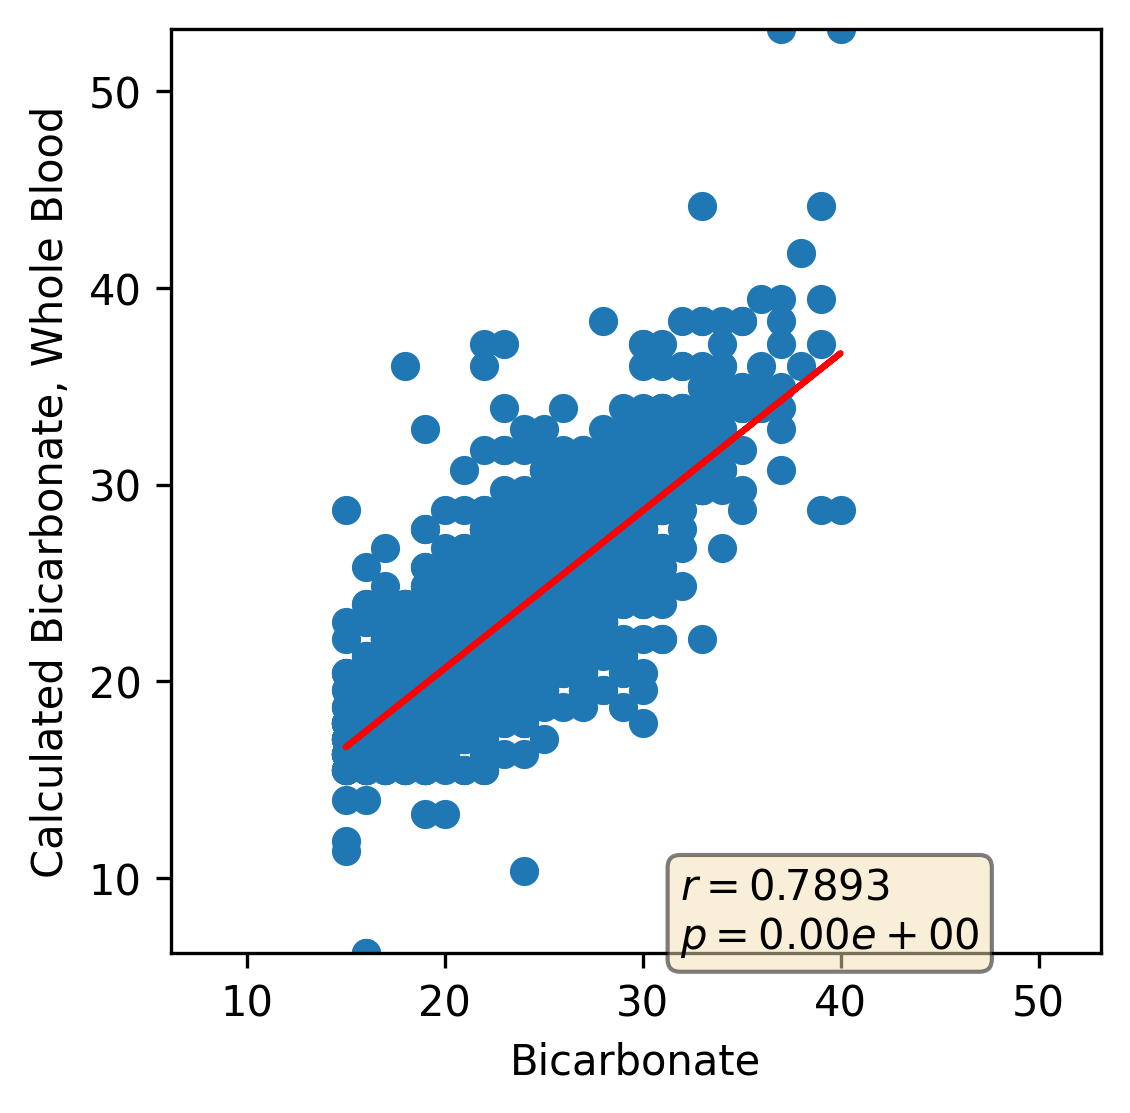

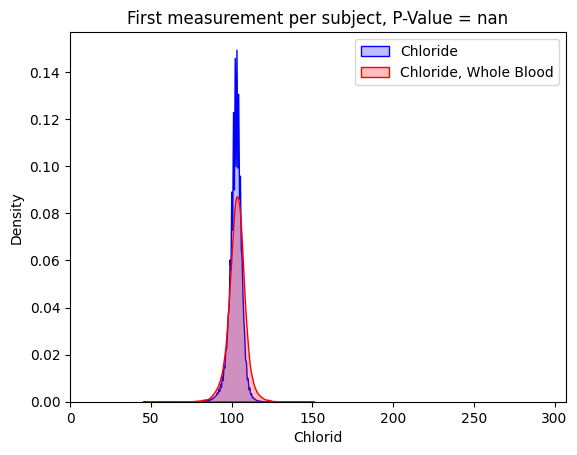

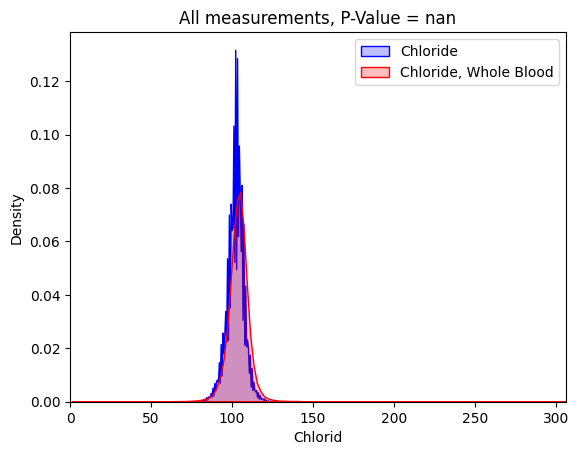

Feature:Chlorid, T=5


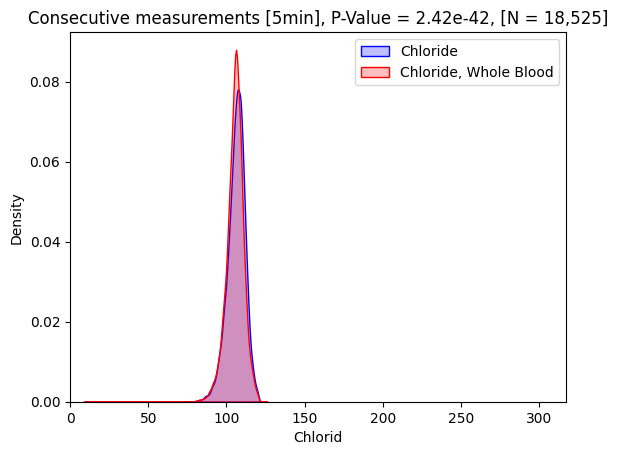

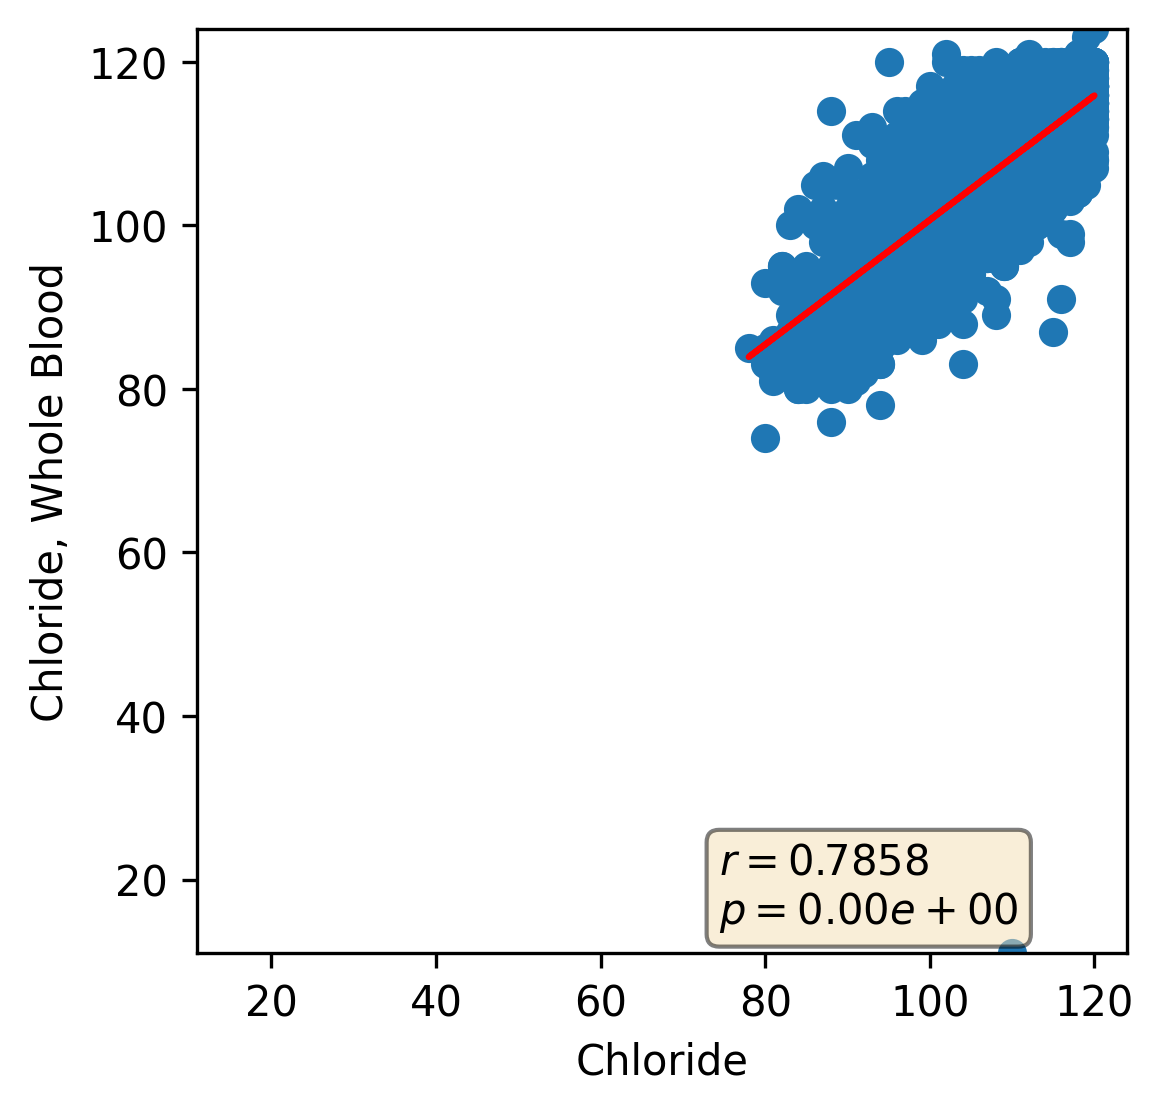

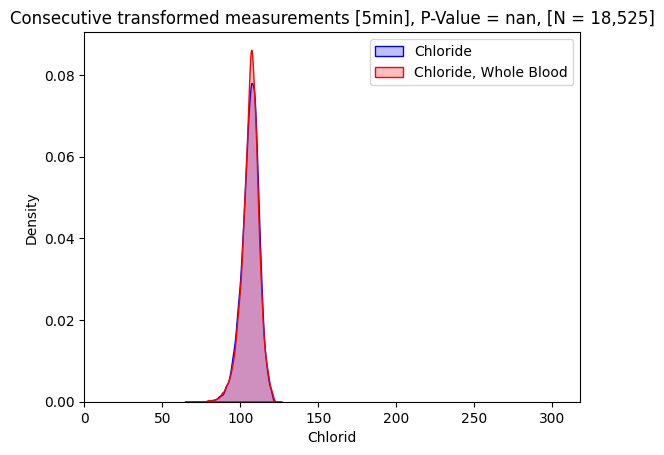

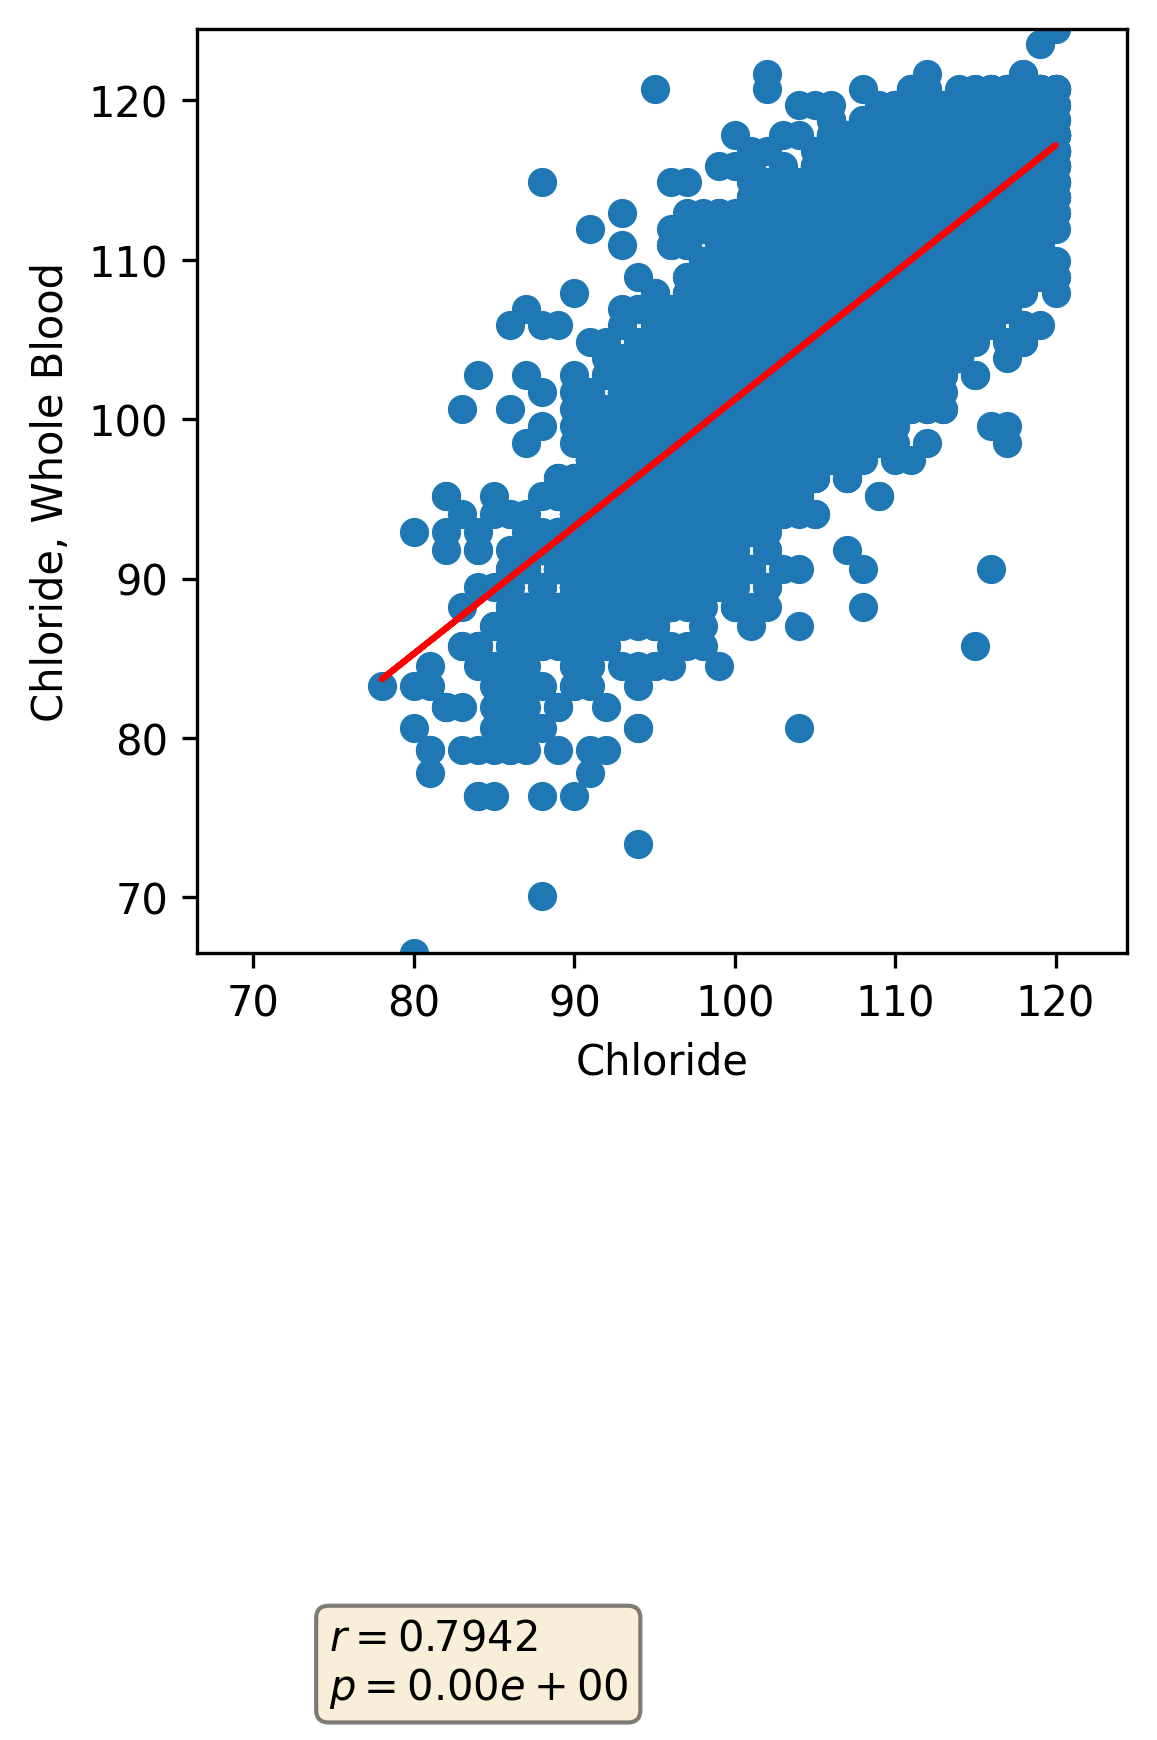

Feature:Chlorid, T=10


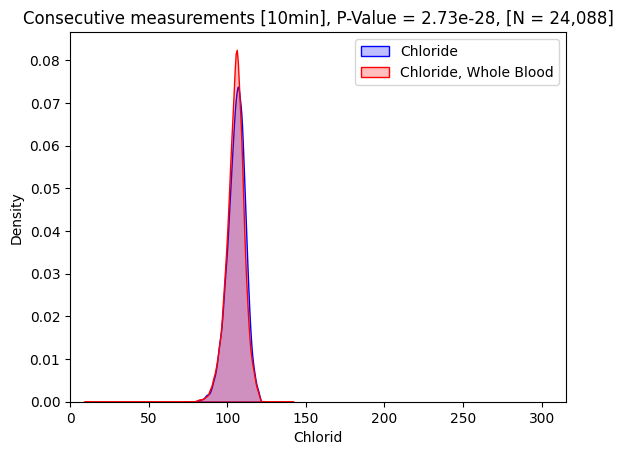

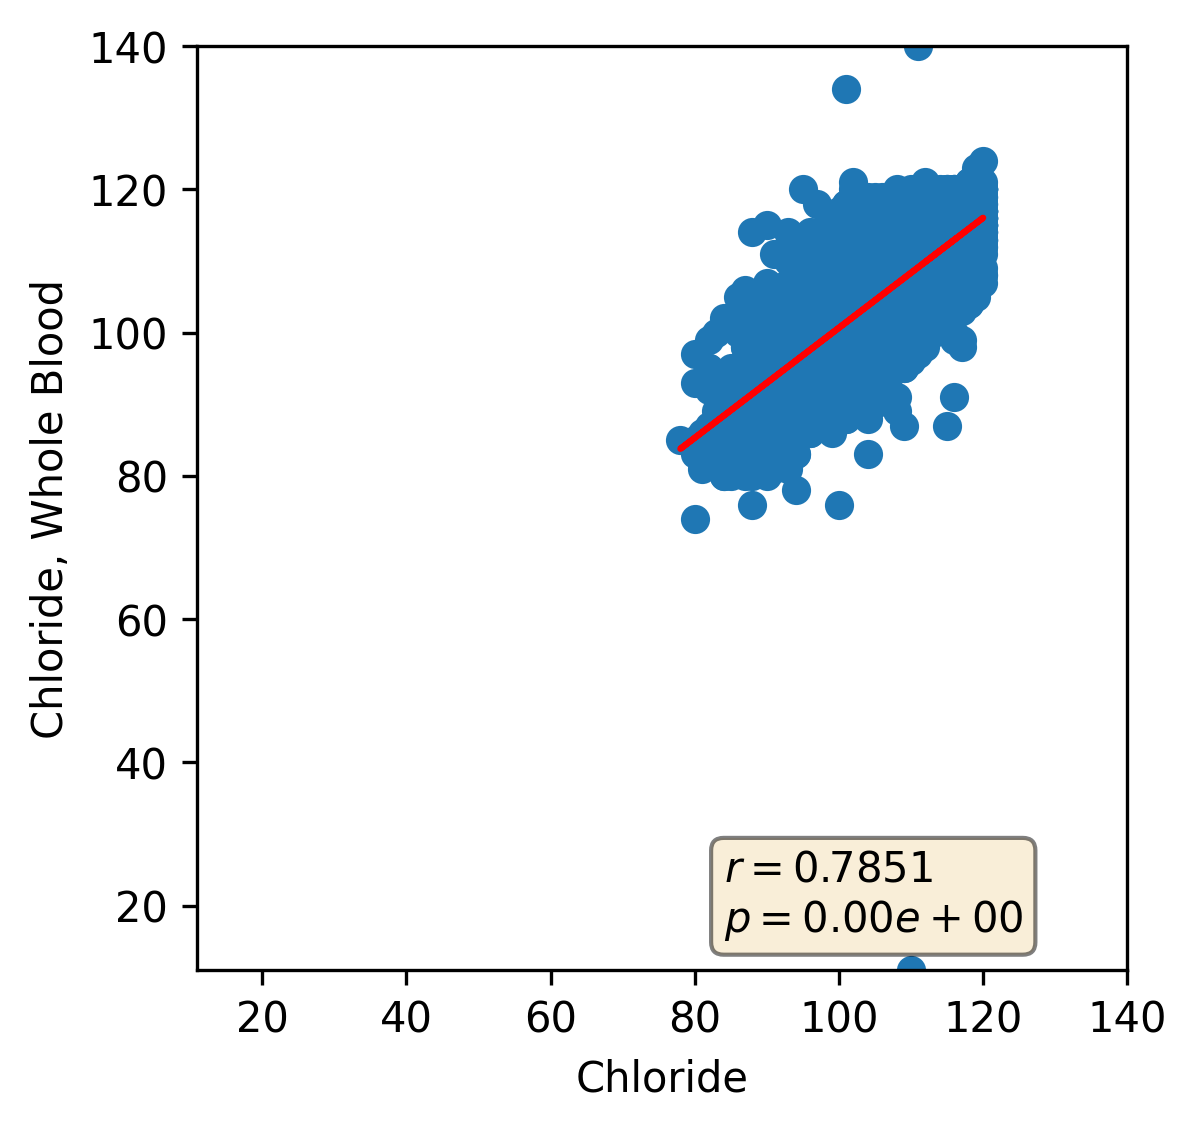

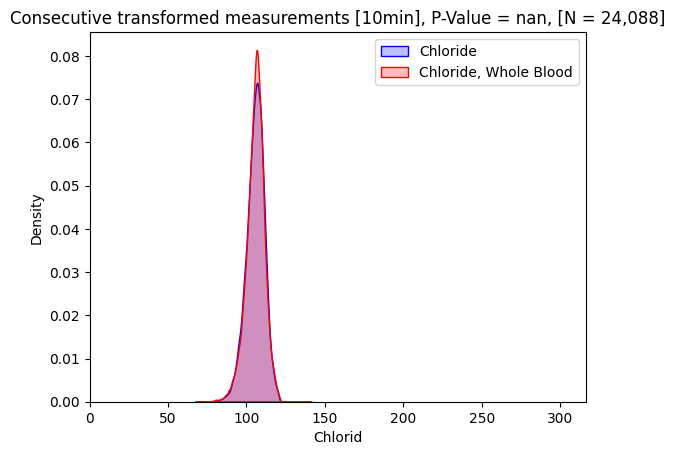

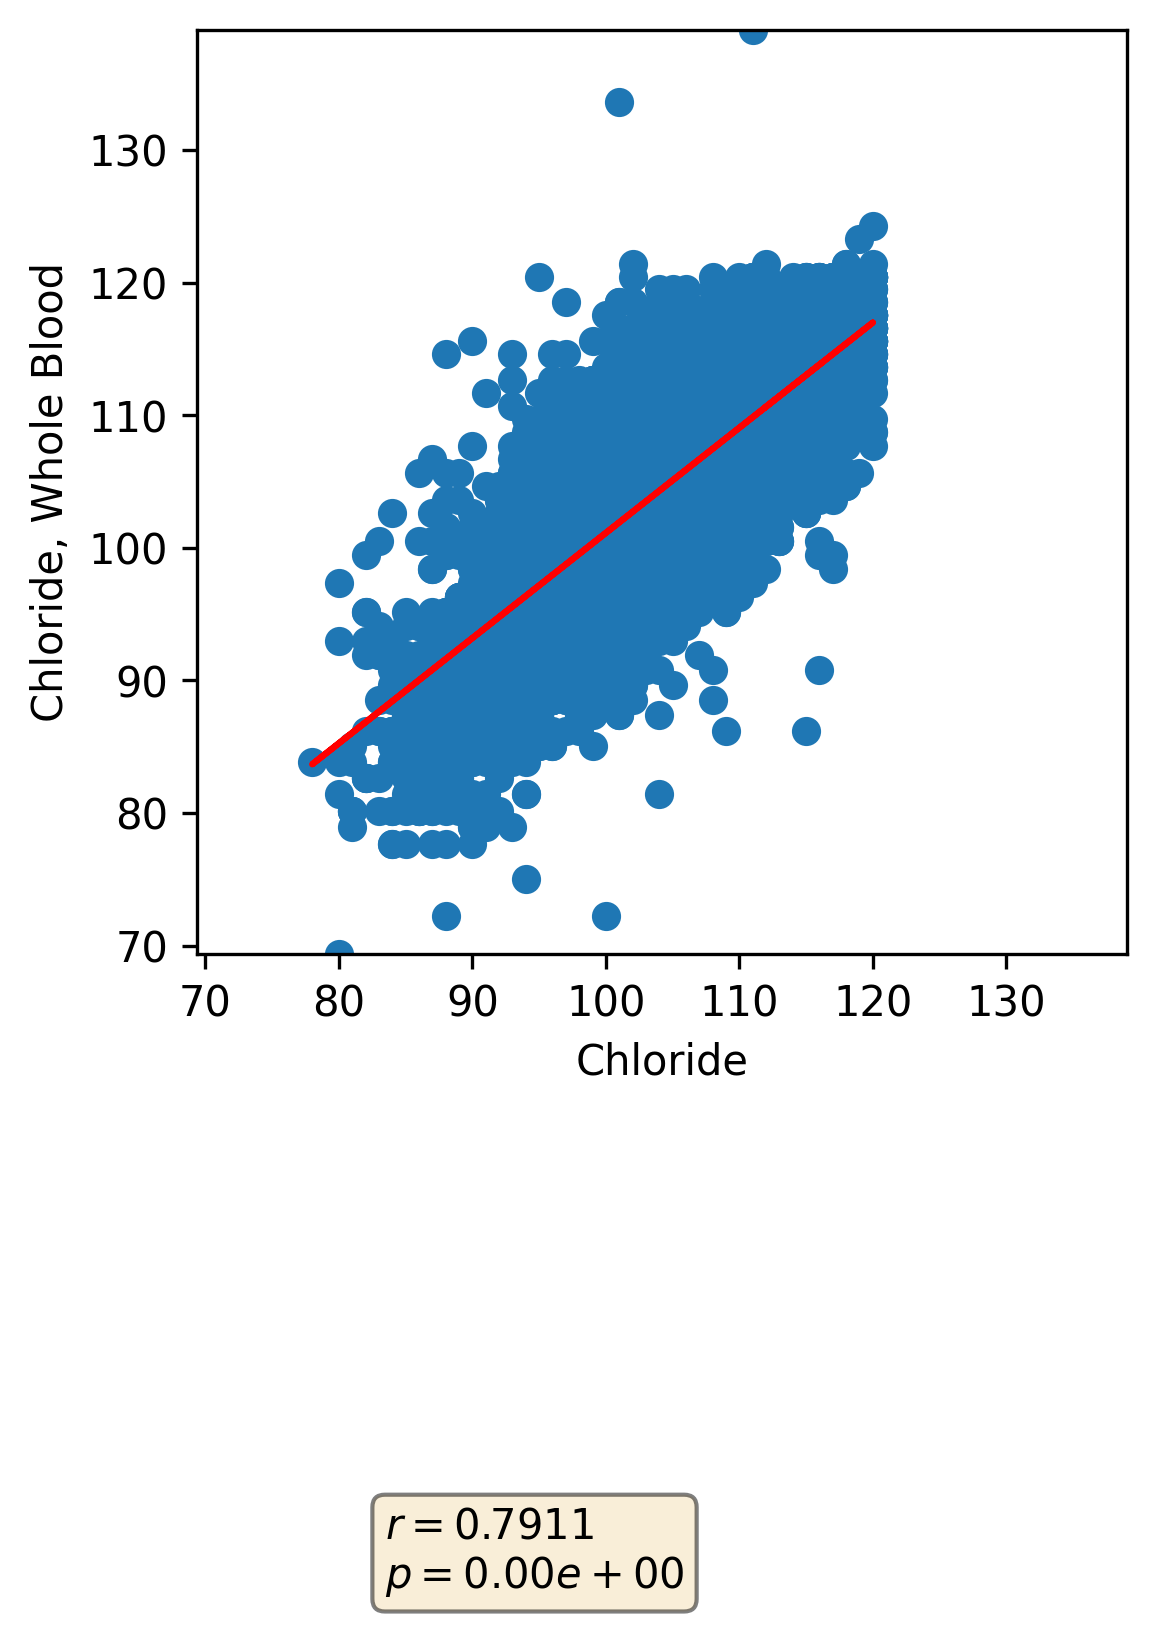

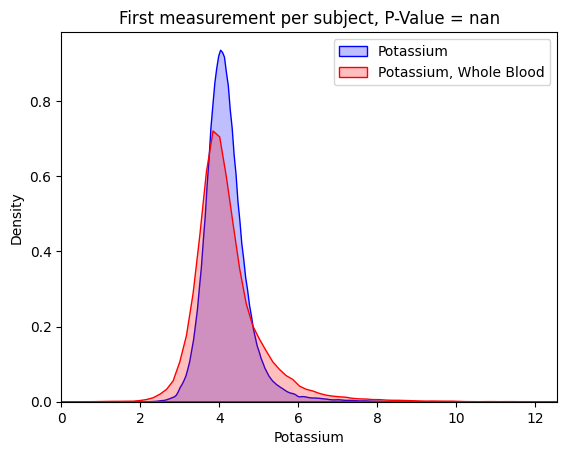

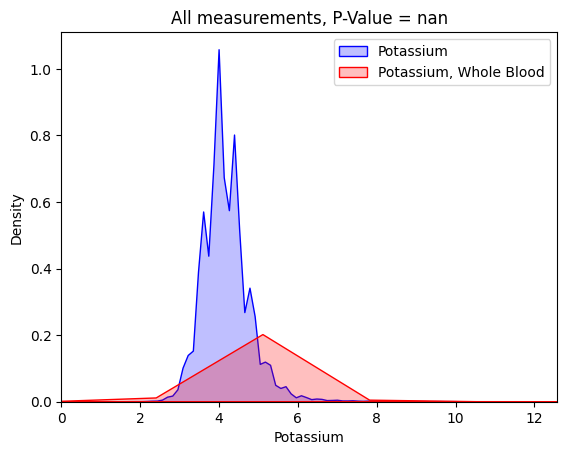

Feature:Potassium, T=5


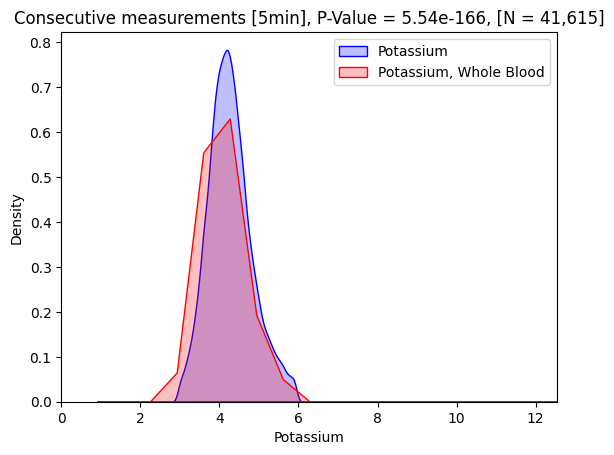

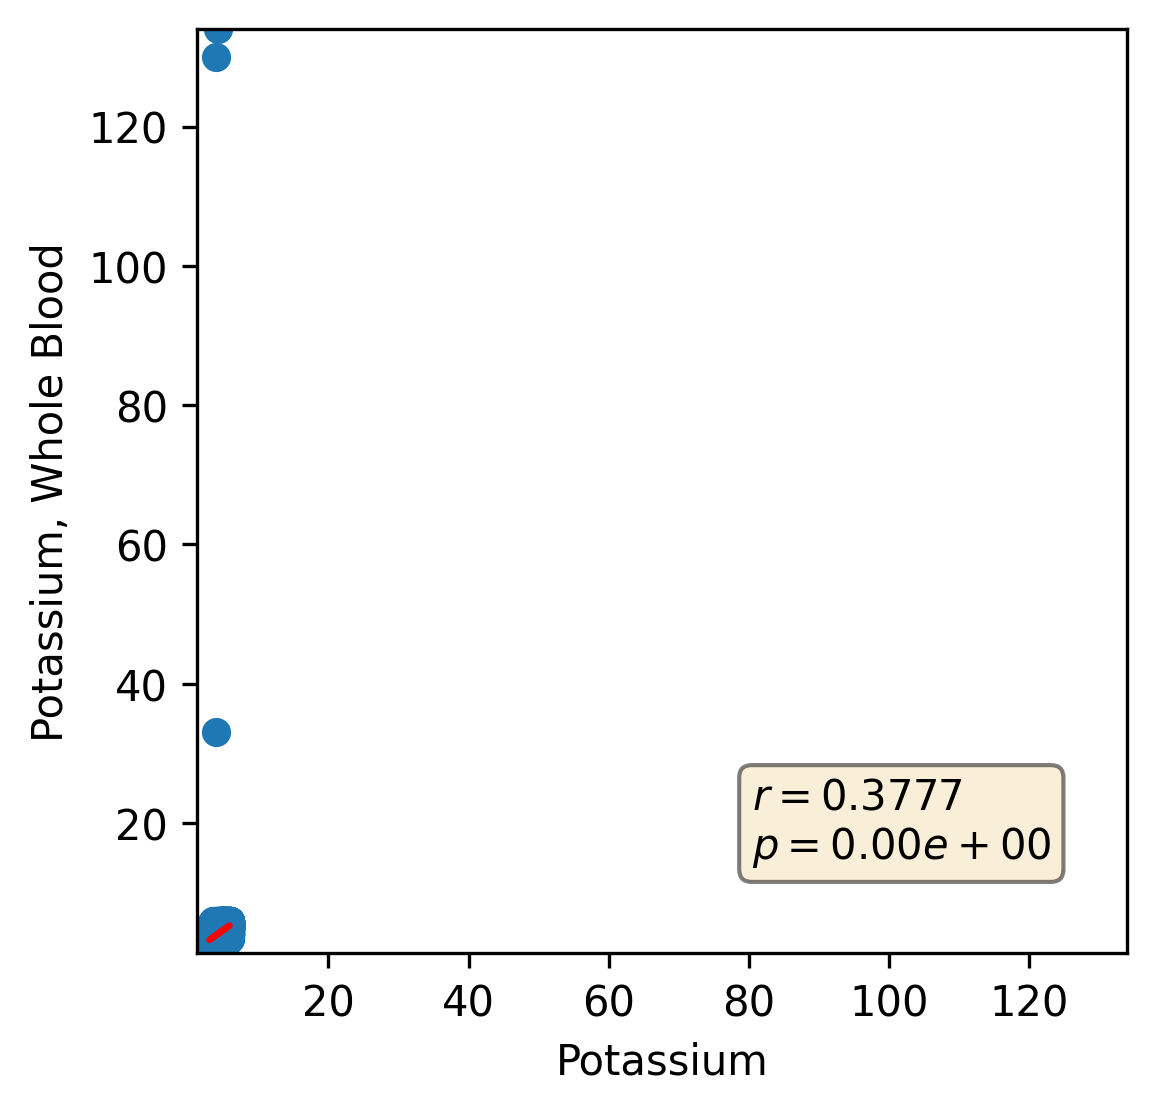

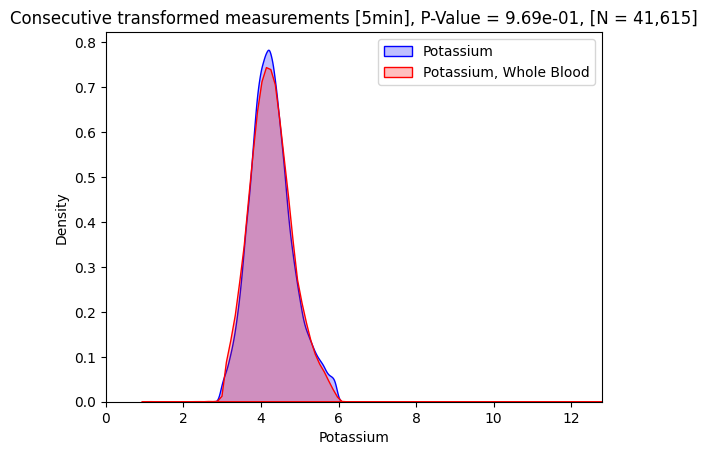

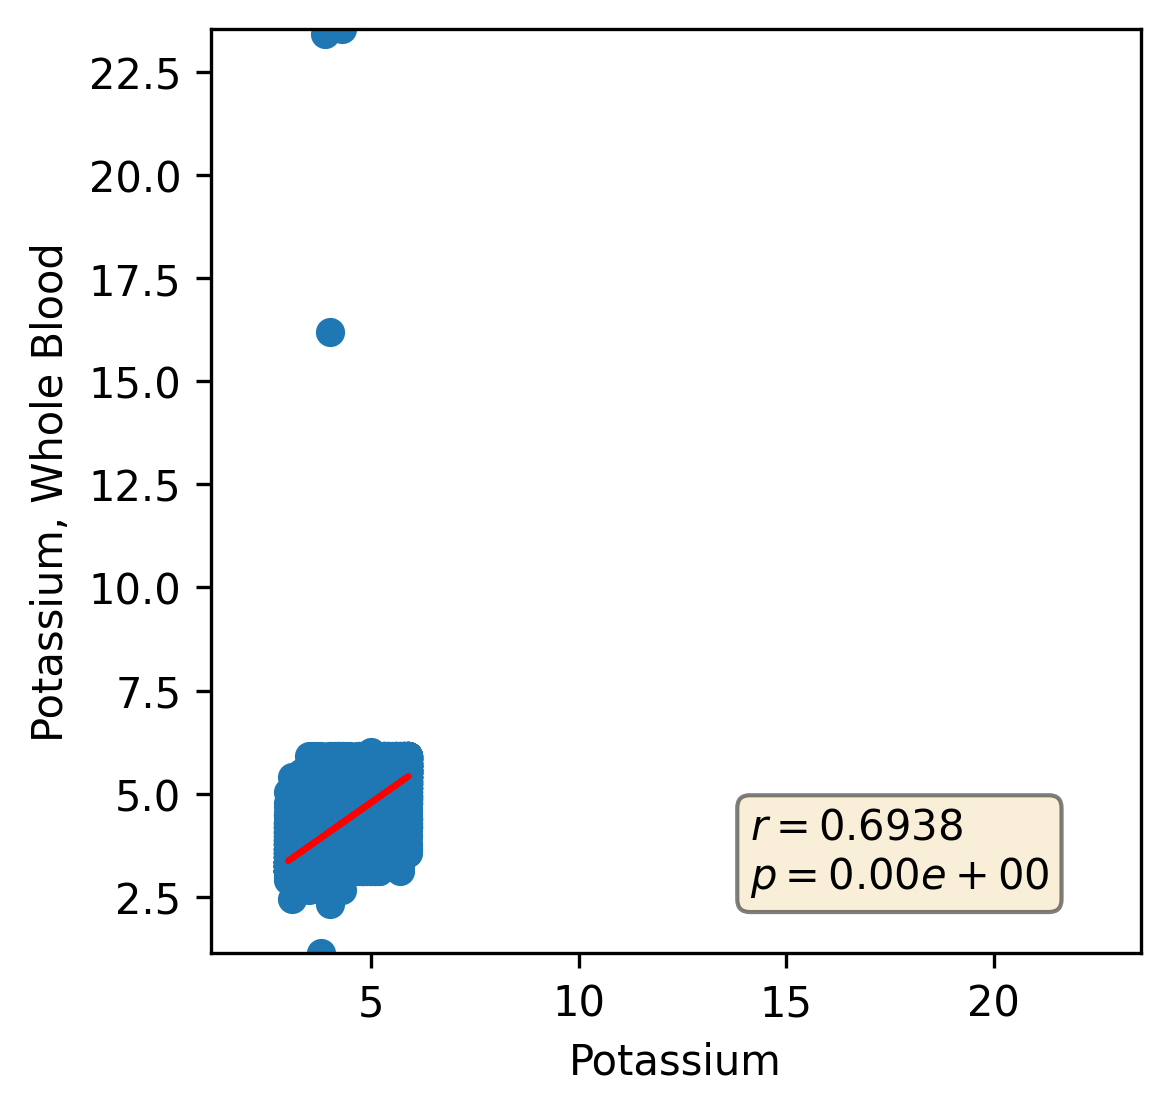

Feature:Potassium, T=10


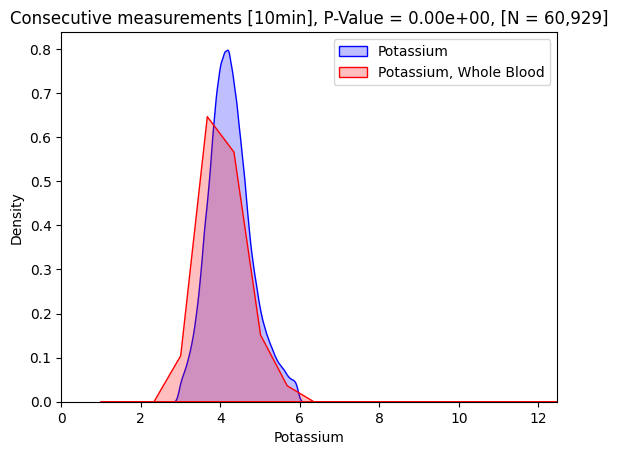

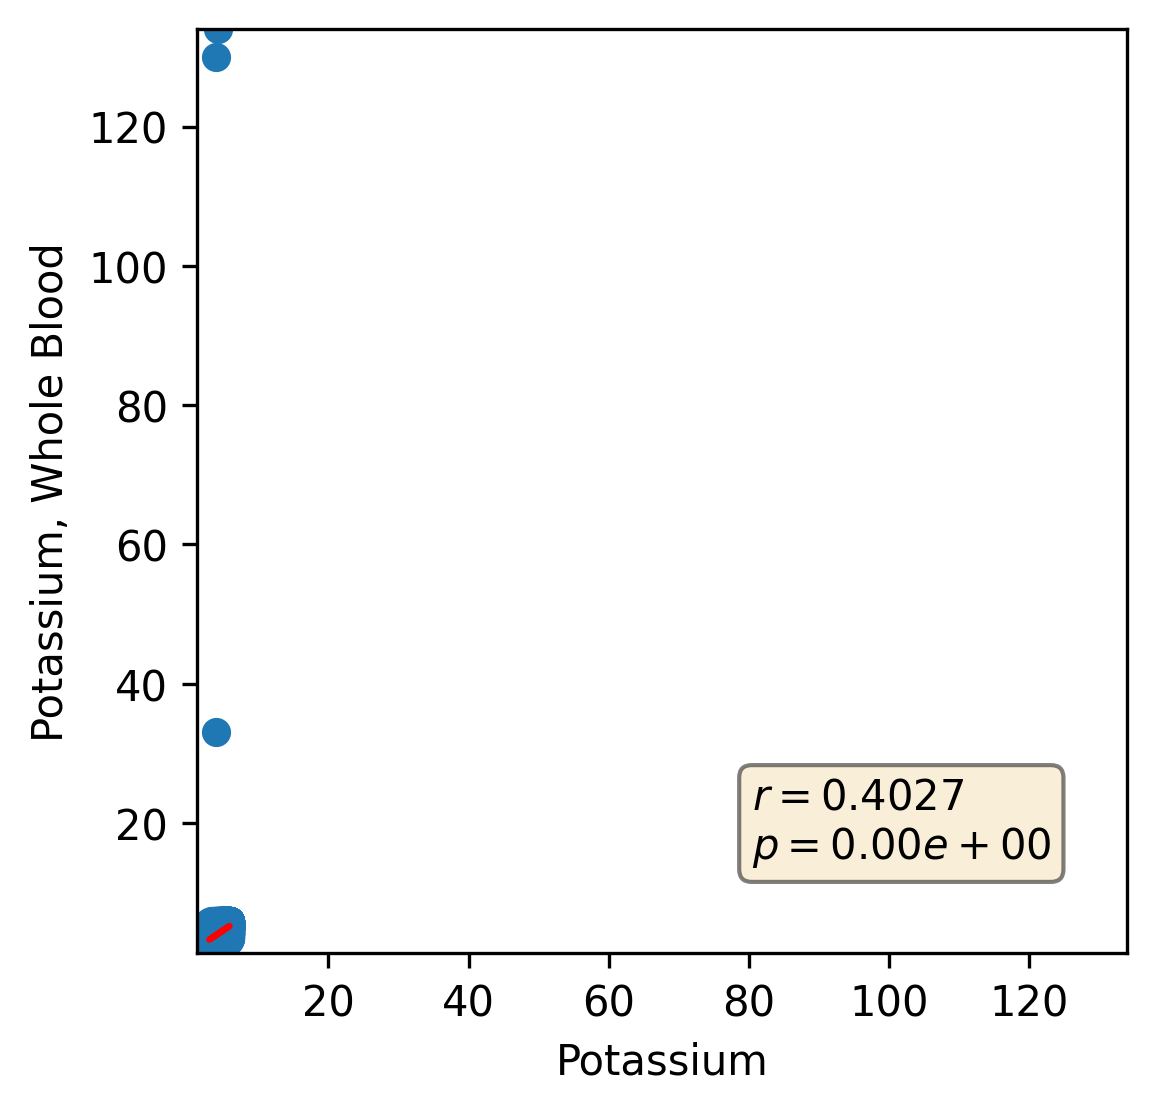

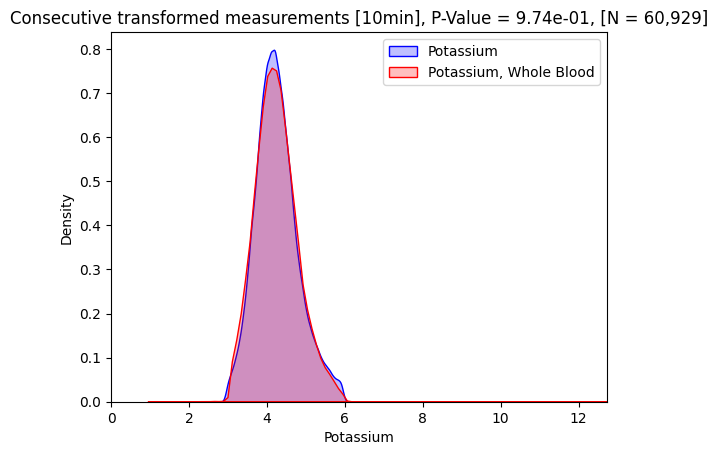

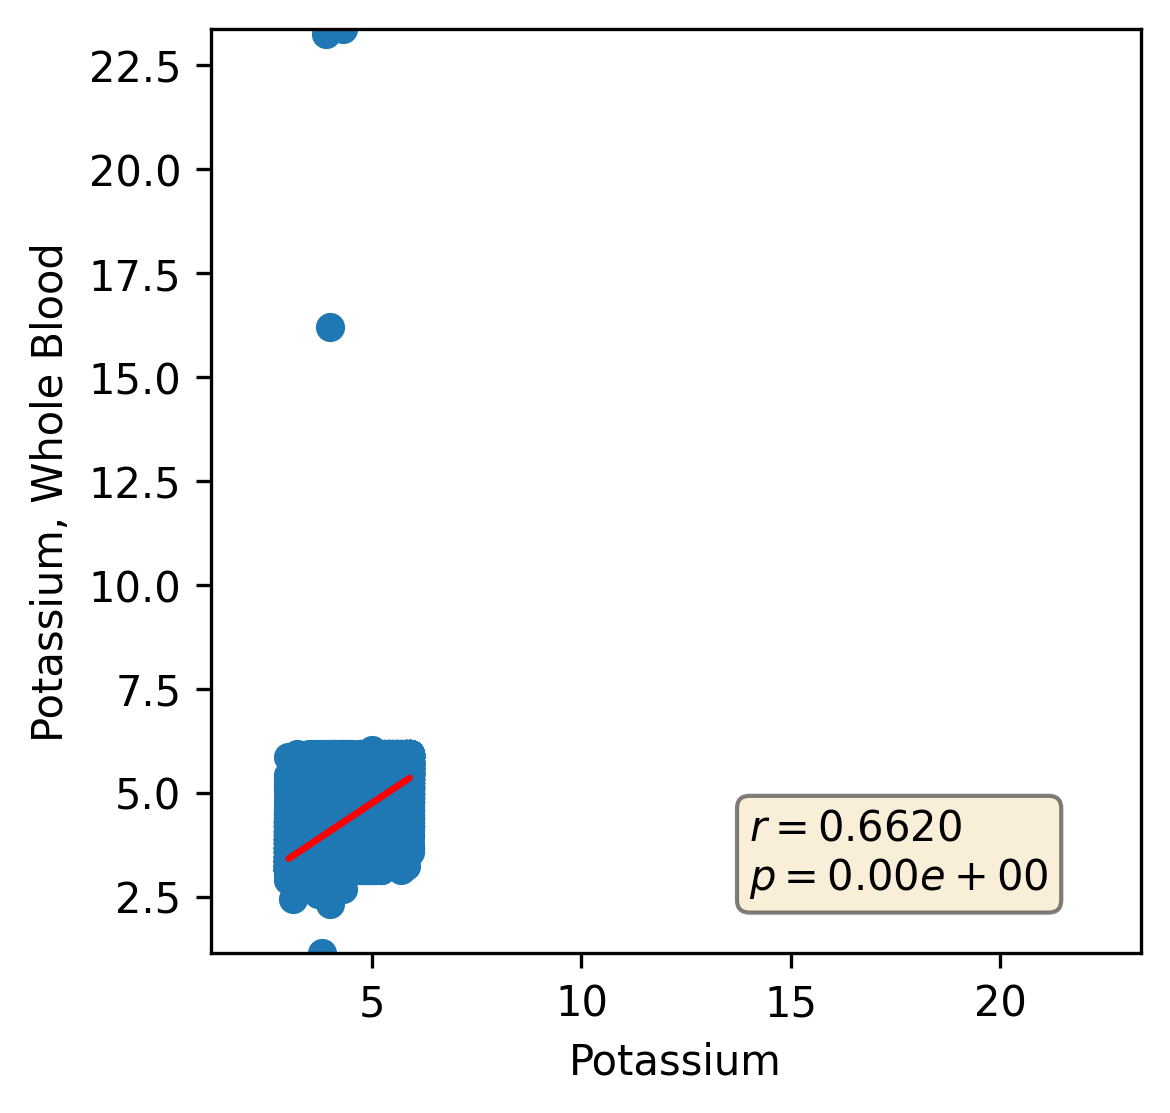

In [39]:
df_res = pd.DataFrame(columns=['Feature','Time','P_val_t','R_t','P_val_nt','R_nt'])

#t_lab_name = 'Hemoglobin'

for t_lab_name in LAB_MAPPING.keys():
    #Extract most common and 2nd common ids per lab name from the full cohort
    counts_per_id = df[df[COLNAMES_DICT['ITEM_ID_COL']].isin(LAB_MAPPING[t_lab_name])][COLNAMES_DICT['ITEM_ID_COL']].value_counts()
    top_id = counts_per_id.index[0]
    next_id = counts_per_id.index[1]


    all_measurements_plot(df,COLNAMES_DICT, t_lab_name,'first',top_id,next_id)
    all_measurements_plot(df,COLNAMES_DICT, t_lab_name,'all',top_id,next_id)
    #all_measurements_plot(df,COLNAMES_DICT, FEATURE_NAME,is_first=True)

    # load conssecutive measurements
    df_lab = pd.read_csv(f'mimic_iv_{t_lab_name}_consecutive.csv', index_col=[0])

    # remove last rows per patient
    df_lab = df_lab[(df_lab['next_VALUENUM'] != 'END') & (df_lab[COLNAMES_DICT['VALUE_COL']] != 'END')]

    # covnvert values to numeric values
    df_lab['next_VALUENUM'] = pd.to_numeric(df_lab['next_VALUENUM'])
    df_lab[COLNAMES_DICT['VALUE_COL']] = pd.to_numeric(df_lab[COLNAMES_DICT['VALUE_COL']])

    #exclude inhuman values
    df_lab = df_lab[(df_lab[COLNAMES_DICT['VALUE_COL']] >0) & (df_lab['next_VALUENUM'] >0)]
    df_lab = df_lab[(df_lab[COLNAMES_DICT['VALUE_COL']] <1000) & (df_lab['next_VALUENUM'] <1000)]


    #max_int = 2 #minutes
    for max_int in [5,10]:
        print(f'Feature:{t_lab_name}, T={max_int}')
        # Take only subset with consecutive measurements lower than max-int
        df_lab_t = df_lab[df_lab.delta_time < max_int]
        # Exlude nan values
        df_lab_t = df_lab_t[(~df_lab_t[COLNAMES_DICT['VALUE_COL']].isna()) & (~df_lab_t.next_VALUENUM.isna())]

        next_values = df_lab_t[['next_ITEMID','next_VALUENUM']].rename(columns={"next_ITEMID": COLNAMES_DICT['ITEM_ID_COL'], "next_VALUENUM": COLNAMES_DICT['VALUE_COL']})
        current_values =  df_lab_t[[COLNAMES_DICT['ITEM_ID_COL'],COLNAMES_DICT['VALUE_COL']]]

        total_data = pd.concat([current_values,next_values],axis =0)
        total_data[COLNAMES_DICT['ITEM_ID_COL']] = pd.to_numeric(total_data[COLNAMES_DICT['ITEM_ID_COL']])

        p_val_non_trasnformed = all_measurements_plot(total_data,COLNAMES_DICT, t_lab_name,'consecutive',top_id,next_id, max_int)
        p_corr_non_trasnformed, corr_non_trasnformed = correlation_plot(lab_metadata,total_data,COLNAMES_DICT,top_id,next_id,'non_trasnformed')

        top_box_lambda,mu_top,sig_top, total_data_boxcox = box_cox_transform(total_data,top_id,next_id,COLNAMES_DICT)

        p_val_trasnformed = all_measurements_plot(total_data_boxcox,COLNAMES_DICT, t_lab_name,'consecutive_transformed',top_id,next_id, max_int)
        p_corr_trasnformed, corr_trasnformed = correlation_plot(lab_metadata,total_data_boxcox,COLNAMES_DICT,top_id,next_id,'trasnformed')

        tempRow = [t_lab_name, max_int,p_corr_trasnformed, corr_trasnformed,p_val_non_trasnformed,corr_non_trasnformed]
        df_res = df_res.append(pd.Series(tempRow, index=df_res.columns), ignore_index=True)

In [41]:
df_res['per'] = round(100*((df_res['R_t'] - df_res['R_nt'])/df_res['R_nt']),4)
df_res

Feature Time  P_val_t       R_t       P_val_nt      R_nt      per
0    Hemoglobin    5      0.0  0.818104   3.311611e-03  0.804939   1.6355
1    Hemoglobin   10      0.0  0.810338   1.641501e-01  0.776708   4.3298
2    Hematocrit    5      0.0  0.748830   3.524463e-01  0.771970  -2.9976
3    Hematocrit   10      0.0  0.731348   9.850450e-01  0.743170  -1.5907
4       Glucose    5      0.0  0.806922   2.973031e-19  0.806337   0.0726
5       Glucose   10      0.0  0.717418   6.214268e-21  0.717068   0.0488
6   Bicarbonate    5      0.0  0.803695   1.381809e-10  0.803718  -0.0028
7   Bicarbonate   10      0.0  0.789320   8.624910e-13  0.790271  -0.1203
8       Chlorid    5      0.0  0.794241   2.417472e-42  0.785792   1.0752
9       Chlorid   10      0.0  0.791097   2.734078e-28  0.785067   0.7680
10    Potassium    5      0.0  0.693771  5.540362e-166  0.377685  83.6903
11    Potassium   10      0.0  0.662010   0.000000e+00  0.402691  64.3964

In [272]:
from tqdm.autonotebook import tqdm
#tqdm(mininterval=60) #miniters= 50
from random import sample

t_lab_name = 'Chloride' #'Potassium', 'Sodium', 'Bicarbonate'

t_ids = art_vein_mapping[art_vein_mapping.lab_name == t_lab_name][['artery_itemid', 'vein_itemid']].reset_index(drop=True).loc[0,:].to_list()
subject_ids = df_labs_mimic.SUBJECT_ID.unique()
#subject_ids = sample(subject_ids.tolist(),1000)

df_lab = extract_consecutive_measurement(df_labs_mimic, subject_ids[0],t_ids)

for t_subject_id in tqdm(subject_ids, mininterval=60):
    t_df_pat_sum = extract_consecutive_measurement(df_labs_mimic, t_subject_id,t_ids)
    df_pat_sum = pd.concat([df_pat_sum,t_df_pat_sum])

df_pat_sum.to_csv(f'{t_lab_name}.csv')
#xdd.loc[xdd['ITEMID'].shift(-1) != xdd['ITEMID']]

100%|█████████████████████████████████████████████████████████████████████████| 46250/46250 [5:15:37<00:00,  2.44it/s]


In [127]:
def extract_consecutive_measurement(df_labs_mimic, t_subject_id,t_ids):
    #extract patient data
    df_pat = df_labs_mimic[(df_labs_mimic['SUBJECT_ID'] == t_subject_id) & df_labs_mimic.ITEMID.isin(t_ids)]
    
    # sort patient data in ascending order and filter shifted rows
    asc_sorted = df_pat.sort_values(by='CHARTTIME', ascending=True)
    asc_sorted = asc_sorted.loc[asc_sorted['ITEMID'].shift(-1) != asc_sorted['ITEMID']]

    # sort patient data in descending order and filter shifted rows
    dsc_sorted = df_pat.sort_values(by='CHARTTIME', ascending=False)
    dsc_sorted = dsc_sorted.loc[dsc_sorted['ITEMID'].shift(-1) != dsc_sorted['ITEMID']]

    # take only rows from asc_sorted and dsc_sorted to exlude 'intervals' of measurenments with the same item id
    df_pat_sum = df_pat[df_pat.ROW_ID.isin(dsc_sorted.ROW_ID.to_list()+asc_sorted.ROW_ID.to_list())].drop_duplicates()
    df_pat_sum = df_pat_sum.sort_values(by='CHARTTIME', ascending=True)

    # calculate time difference between each consecutive rows
    df_pat_sum['CHARTTIME'] = pd.to_datetime(df_pat_sum['CHARTTIME'])
    df_pat_sum['delta_time'] = df_pat_sum['CHARTTIME'].diff() / pd.Timedelta(1, unit='h')
    
    # create col for the next value and item id
    df_pat_sum['next_VALUENUM'] = df_pat_sum.groupby('SUBJECT_ID')['VALUENUM'].shift(1, fill_value='END')
    df_pat_sum['next_ITEMID'] = df_pat_sum.groupby('SUBJECT_ID')['ITEMID'].shift(1, fill_value='END')
    
    #detect rows with the different ITEMIDs on the next row 
    df_pat_sum['diff_ids'] = df_pat_sum['ITEMID'].diff() 
    df_pat_sum = df_pat_sum[~df_pat_sum.diff_ids.isna()]
    df_pat_sum['diff_ids'] = (df_pat_sum['diff_ids'] != 0)
    
    #filter only rows with different ITEMISa
    
    df_pat_sum = df_pat_sum[df_pat_sum['diff_ids'] == True]
    
    return(df_pat_sum)
    #df_pat_sum[df_pat_sum.diff_ids == True]
    #df_pat_sum.sort_values(by='CHARTTIME', ascending=True)
    #xdd2['CHARTTIME'] = pd.to_datetime(xdd2['CHARTTIME'])
    #xdd2['delta_time'] = xdd2['CHARTTIME'].diff() / pd.Timedelta(1, unit='h')
    #xdd2.loc[::2, 'delta_time'] ='bla'
    ##pd.to_datetime(xdd2.reset_index().loc[0,'CHARTTIME']) - pd.to_datetime(xdd2.reset_index().loc[1,'CHARTTIME'])
    #xdd2
    #xdd.ITEMID.value_counts()
    #dd['SUBJECT_ID'].value_counts().sort_values()


In [260]:
max_int = 0.16
df_lab_t = df_pat_sum[df_pat_sum.delta_time < max_int]
df_lab_t = df_lab_t[(~df_lab_t.VALUENUM.isna()) & (~df_lab_t.next_VALUENUM.isna())]

len(df_lab_t.SUBJECT_ID.unique())
total_data.ITEMID.value_counts()

50810    9508
51221    9508
51222    9275
50811    9275
50809    8095
50931    8095
Name: ITEMID, dtype: int64

mean of vein 29.19
median of vein 28.4
mean of artery 30.59
median of artery 30.0
Paired T-test p-value=0.0
N=9508


C:\Users\danco\AppData\Local\Temp\ipykernel_16096\3556798616.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(venous_result, shade=True, color="b", label='Vein')
C:\Users\danco\AppData\Local\Temp\ipykernel_16096\3556798616.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(arterial_result, shade=True, color="r", label='Artery')


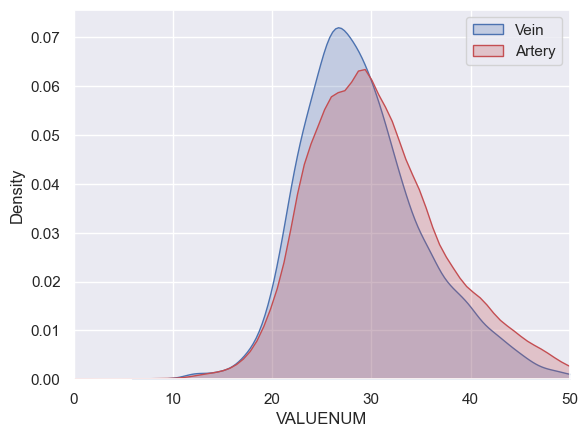

In [274]:
import scipy.stats as stats
t_lab_name = 'Hematocrit'

max_int = 0.16
df_lab_t = df_pat_sum[df_pat_sum.delta_time < max_int]

df_lab_t = df_lab_t[(~df_lab_t.VALUENUM.isna()) & (~df_lab_t.next_VALUENUM.isna())]
#rename cols
next_values = df_lab_t[['next_ITEMID','next_VALUENUM']].rename(columns={"next_ITEMID": "ITEMID", "next_VALUENUM": "VALUENUM"})

#merge cols
total_data = pd.concat([df_lab_t[['ITEMID','VALUENUM']],next_values],axis =0)


# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

venous_result = pd.to_numeric(total_data[total_data.ITEMID.isin([art_vein_mapping[art_vein_mapping.lab_name == t_lab_name]['vein_itemid'].reset_index(drop=True)[0]])]['VALUENUM'])
print(f'mean of vein {round(venous_result.mean(),2)}')
print(f'median of vein {round(venous_result.median(),2)}')

arterial_result = pd.to_numeric(total_data[total_data.ITEMID.isin([art_vein_mapping[art_vein_mapping.lab_name == t_lab_name]['artery_itemid'].reset_index(drop=True)[0]])]['VALUENUM'])
print(f'mean of artery {round(arterial_result.mean(),2)}')
print(f'median of artery {round(arterial_result.median(),2)}')

print(f'Paired T-test p-value={round(stats.ttest_rel(venous_result,arterial_result)[1],10)}')
print(f'N={len(arterial_result)}')
# plotting both distibutions on the same figure
fig = sns.kdeplot(venous_result, shade=True, color="b", label='Vein')
fig = sns.kdeplot(arterial_result, shade=True, color="r", label='Artery')
plt.xlim(0,50)
plt.legend()
plt.show()

In [161]:
stats.ttest_rel(venous_result,arterial_result)

0.10337958116681521

In [16]:
xdd = dd[dd['SUBJECT_ID'] == 5727].sort_values(by='CHARTTIME', ascending=False)
xdd2 = xdd.loc[xdd['ITEMID'].shift(-1) != xdd['ITEMID']]
xdd2['CHARTTIME'] = pd.to_datetime(xdd2['CHARTTIME'])
xdd2['delta_time'] = xdd2['CHARTTIME'].diff() / pd.Timedelta(1, unit='h')
xdd2.loc[::2, 'delta_time'] ='bla'
#pd.to_datetime(xdd2.reset_index().loc[0,'CHARTTIME']) - pd.to_datetime(xdd2.reset_index().loc[1,'CHARTTIME'])
xdd2

C:\Users\danco\AppData\Local\Temp\ipykernel_16096\2978362592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdd2['CHARTTIME'] = pd.to_datetime(xdd2['CHARTTIME'])
C:\Users\danco\AppData\Local\Temp\ipykernel_16096\2978362592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdd2['delta_time'] = xdd2['CHARTTIME'].diff() / pd.Timedelta(1, unit='h')


ROW_ID  SUBJECT_ID   HADM_ID  ITEMID           CHARTTIME VALUE  \
3652672  3598318        5727       NaN   51222 2155-09-21 18:50:00  14.1   
3652646  3598292        5727       NaN   50811 2155-09-21 18:49:00  15.2   
3662463  3598012        5727  114887.0   51222 2155-08-17 04:20:00  13.4   
3662425  3597974        5727  114887.0   50811 2155-08-16 20:02:00  17.5   
3639726  3595051        5727       NaN   51222 2154-04-09 14:00:00   6.4   
3639674  3594999        5727       NaN   50811 2154-04-09 09:12:00   6.6   
3470641  3594433        5727  188983.0   51222 2154-02-08 00:01:00   5.8   
3448162  3594393        5727  188983.0   50811 2154-02-07 09:37:00   7.3   
3448146  3594377        5727  188983.0   51222 2154-02-07 04:34:00   6.8   
3448117  3594347        5727  188983.0   50811 2154-02-06 22:00:00   7.7   
3450821  3593149        5727       NaN   51222 2153-08-29 16:24:00   9.0   
3450795  3593123        5727       NaN   50811 2153-08-29 15:41:00  10.3   
3468126  3591313        5727       NaN   51222 2153-05-19 05:22:00   8.9   
3468068  3591255        5727       NaN   50811 2153-05-18 13:48:00   7.0   
3468345  3589682        5727       NaN   51222 2152-03-07 17:37:00   9.4   
3448294  3589664        5727       NaN   50811 2152-03-06 14:21:00   4.9   
3455194  3588975        5727  101587.0   51222 2151-09-29 10:00:00   3.9   

         VALUENUM VALUEUOM      FLAG delta_time  
3652672      14.1     g/dL       NaN        bla  
3652646      15.2     g/dL       NaN  -0.016667  
3662463      13.4     g/dL  abnormal        bla  
3662425      17.5     g/dL       NaN       -8.3  
3639726       6.4     g/dL  abnormal        bla  
3639674       6.6     g/dL  abnormal       -4.8  
3470641       5.8     g/dL  abnormal        bla  
3448162       7.3     g/dL  abnormal      -14.4  
3448146       6.8     g/dL  abnormal        bla  
3448117       7.7     g/dL  abnormal  -6.566667  
3450821       9.0     g/dL  abnormal        bla  
3450795      10.3     g/dL  abnormal  -0.716667  
3468126       8.9     g/dL  abnormal        bla  
3468068       7.0     g/dL  abnormal -15.566667  
3468345       9.4     g/dL  abnormal        bla  
3448294       4.9     g/dL  abnormal -27.266667  
3455194       3.9     g/dL  abnormal        bla

In [ ]:
# take subset only of the most close pairs of measurement per subject ID and their time difference
# compare dist of Art vs. Vein
# calculate the difference of art & vein ratio/difference and its correlation to mortality/discharge
# read in mimic git on Arterial and Venous measurement
# enrich the list (currentky only hemoglobin)
# 

In [69]:
import os
import pandas as pd
data_hirid ="C:\\Users\\danco\\My Drive\\Master\\Datasets\\HiRID\\data\\hirid-a-high-time-resolution-icu-dataset-1.1.1\\hirid-a-high-time-resolution-icu-dataset-1.1.1"
n_parts = (0,10)

observation_tables_paths = sorted([i for iq, i in enumerate(os.walk(os.path.join(data_hirid,'raw_stage','observation_tables'))) if iq==1][0][2])
observation_tables_paths = [f for f in observation_tables_paths if f.endswith('.csv')]
#observation_tables_part = pd.concat([pd.read_csv(os.path.join(data, "observation_tables", 'csv', file) for file in observation_tables_paths[n_parts[0] : min(len(observation_tables_paths), n_parts[1])])

observation_tables_part = pd.concat([pd.read_csv(os.path.join(data_hirid,'raw_stage','observation_tables', 'csv',  file)) for file in observation_tables_paths[n_parts[0]: n_parts[1]]])

C:\Users\danco\AppData\Local\Temp\ipykernel_6548\3500614558.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  observation_tables_part = pd.concat([pd.read_csv(os.path.join(data_hirid,'raw_stage','observation_tables', 'csv',  file)) for file in observation_tables_paths[n_parts[0]: n_parts[1]]])
C:\Users\danco\AppData\Local\Temp\ipykernel_6548\3500614558.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  observation_tables_part = pd.concat([pd.read_csv(os.path.join(data_hirid,'raw_stage','observation_tables', 'csv',  file)) for file in observation_tables_paths[n_parts[0]: n_parts[1]]])
C:\Users\danco\AppData\Local\Temp\ipykernel_6548\3500614558.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  observation_tables_part = pd.concat([pd.read_csv(os.path.join(data_hirid,'raw_stage','observation_tables', 'csv',  file)) f

In [103]:
observation_tables_part[observation_tables_part.variableid.isin([24000548])]

datetime                entertime  patientid  status  \
238      2183-05-12 13:02:00.000  2183-05-13 01:03:09.033        148       8   
239      2183-05-12 13:02:00.000  2183-05-12 13:06:01.730        148       8   
2444     2183-05-12 20:01:00.000  2183-05-13 01:10:34.800        148       8   
2445     2183-05-12 20:01:00.000  2183-05-12 20:06:56.583        148       8   
5064     2183-05-13 05:58:00.000  2183-05-13 06:04:56.956        148       8   
...                          ...                      ...        ...     ...   
2847395  2160-02-09 16:10:00.000  2160-02-09 16:13:17.963      33694       8   
2853208  2160-02-09 22:01:00.000  2160-02-09 22:04:09.583      33694       8   
2855414  2160-02-10 00:13:00.000  2160-02-10 00:15:18.873      33694       8   
2860029  2160-02-10 05:52:00.000  2160-02-10 05:56:58.950      33694       8   
2865337  2160-02-10 14:08:00.000  2160-02-10 14:12:33.963      33694       8   

        stringvalue type  value  variableid  
238             NaN    F  140.0    24000548  
239             NaN    F  140.0    24000548  
2444            NaN    F  121.0    24000548  
2445            NaN    F  121.0    24000548  
5064            NaN    F  112.0    24000548  
...             ...  ...    ...         ...  
2847395         126    F  126.0    24000548  
2853208         124    F  124.0    24000548  
2855414         122    F  122.0    24000548  
2860029         123    F  123.0    24000548  
2865337         115    F  115.0    24000548  

[10554 rows x 8 columns]

10554
9103


C:\Users\danco\AppData\Local\Temp\ipykernel_6548\207818199.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(venous_result_b, shade=True, color="b", label='Vein')
C:\Users\danco\AppData\Local\Temp\ipykernel_6548\207818199.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(arterial_result, shade=True, color="r", label='Artery')


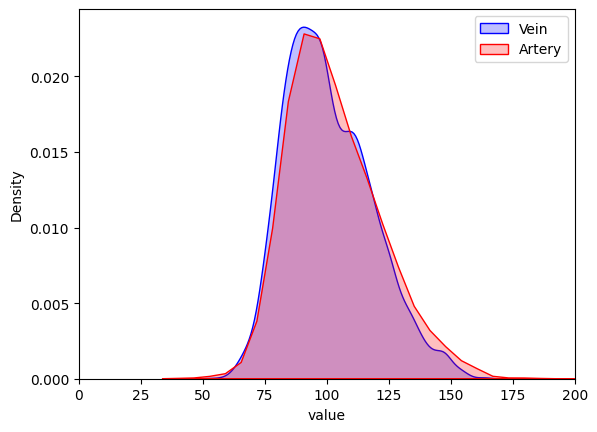

In [102]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import re

arterial_result = observation_tables_part[observation_tables_part.variableid.isin([24000548])]['value']
print(len(arterial_result))
#venous_result = observation_tables_part[observation_tables_part.variableid.isin([20000900,24000836])]['value']

#venous_result_a = observation_tables_part[observation_tables_part.variableid.isin([24000836])]['value']
#print(len(venous_result_a))

venous_result_b = observation_tables_part[observation_tables_part.variableid.isin([20000900])]['value']
print(len(venous_result_b))

# plotting both distibutions on the same figure
#fig = sns.kdeplot(venous_result, shade=True, color="b", label='Vein')
#fig = sns.kdeplot(venous_result_a, shade=True, color="b", label='Vein')
fig = sns.kdeplot(venous_result_b, shade=True, color="b", label='Vein')

fig = sns.kdeplot(arterial_result, shade=True, color="r", label='Artery')
plt.xlim(0,200)
plt.legend()
plt.show()

In [87]:
general_table = pd.read_csv(os.path.join(data_hirid,'reference_data','general_table.csv'))
mapping_df = pd.read_csv(os.path.join(data_hirid,'reference_data','hirid_variable_reference.csv'))
#pd.read_csv(os.path.join(data_hirid,'reference_data','hirid_variable_reference_preprocessed.csv'))
mapping_df[mapping_df['Variable Name'].str.contains('art')]
#xx = pd.read_csv(os.path.join(data_hirid,'reference_data','ordinal_vars_ref.csv'))
#mapping_df[mapping_df['Variable Name'].str.contains('Arterial')]


Source Table        ID                                      Variable Name  \
0    Observation       200                                         Heart rate   
4    Observation       100                Invasive systolic arterial pressure   
5    Observation       120               Invasive diastolic arterial pressure   
6    Observation       110                    Invasive mean arterial pressure   
7    Observation       600            Non-invasive systolic arterial pressure   
8    Observation       620           Non-invasive diastolic arterial pressure   
9    Observation       610                Non-invasive mean arterial pressure   
10   Observation       160                     Pulmonary artery mean pressure   
11   Observation       150                 Pulmonary artery systolic pressure   
12   Observation       170                Pulmonary artery diastolic pressure   
13   Observation       800                    Pulmonary artery wedge pressure   
72   Observation  20001200  Carbon dioxide [Partial pressure] in Arterial ...   
73   Observation  20000200        Oxygen [Partial pressure] in Arterial blood   
105  Observation  24000330  Aspartate aminotransferase [Enzymatic activity...   
202       Pharma   1001080                                Losartan Tabl 50 mg   
230       Pharma   1000596                       Metoprolol Tartrat Tbl 10 mg   

     Unit Additional information  
0    /min                    NaN  
4    mmHg                    NaN  
5    mmHg                    NaN  
6    mmHg                    NaN  
7    mmHg                    NaN  
8    mmHg                    NaN  
9    mmHg                    NaN  
10   mmHg                    NaN  
11   mmHg                    NaN  
12   mmHg                    NaN  
13   mmHg                    NaN  
72   mmHg                    NaN  
73   mmHg                    NaN  
105   U/l                    NaN  
202   NaN                    NaN  
230   NaN                    NaN

In [86]:

hirid_art_vein_mapping = pd.DataFrame({'lab_name':       ['Hemoglobin',        'Lactate',             'Saturation'            ],
                                       'vein_itemid':    [ (20000900,24000836), (24000732,24000485),  (20001000,24000737,4200)],
                                       'artery_itemid':  [ 24000548,            24000524,             20000800]})
hirid_art_vein_mapping

lab_name                 vein_itemid  artery_itemid
0  Hemoglobin        (20000900, 24000836)       24000548
1     Lactate        (24000732, 24000485)       24000524
2  Saturation  (20001000, 24000737, 4200)       20000800